In [2]:
#load dependencies 
import pandas as pd
import numpy as np
from fredapi import Fred
from config import key, pwrd
from tqdm import tqdm, tqdm_notebook
import warnings
import time
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress




In [3]:
#define FRED API call
fred = Fred(api_key= key)

In [4]:
#set column view options
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 50)

In [5]:
# Code to search FRED database
# search = fred.search('500', order_by='popularity', sort_order='desc')
# search_df = pd.DataFrame(search[['title', 'id', 'popularity', 'units','seasonal_adjustment_short']])
# search_df[:20]

In [45]:
#desired indicators
indicators = ['USSLIND', 'UMCSENT', 'CSCICP03USM665S', 'INDPRO', 'TCU','DGORDER', 'NEWORDER', 'PI','BUSINV', 'TOTALSA',
             'MARTSMPCSM44X72USS', 'PAYEMS', 'UNRATE', 'ICSA', 'CCSA', 'CC4WSA', 'NPPTTL', 'CES0500000003', 'HSN1F',
             'EXHOSLUSM495S', 'PERMIT', 'CSUSHPINSA']

In [7]:
print(f'{len(indicators)} indicators to download')

23 indicators to download


In [8]:
#set start date
date = input("Choose start date in mm/dd/yyyy format")

Choose start date in mm/dd/yyyy format01/02/2000


In [9]:
#create FRED dataframe function
def fred_df(series):
    data =  fred.get_series(series, observation_start= date)
    info = fred.get_series_info(series)
    data_df = pd.DataFrame(data)
    data_df.reset_index(level=0, inplace=True)
    info_df = pd.DataFrame(info)
    info_df.reset_index(level=0, inplace=True)
    #pivot info_df
    df_dict = dict(zip(info_df['index'],info_df[0]))
    info_df = pd.DataFrame(df_dict,  index=[0])
    #duplicate info_df rows to equal data_df length
    info_df = pd.concat([info_df]*(len(data_df)), ignore_index=True)
    global combine_df
    #join df's
    combine_df = data_df.join(info_df)
    #rename columns
    combine_df.rename(columns = {'index':'date', 0:'data'}, inplace = True) 
    #create new 'change from last column'
    combine_df.insert(2, 'change', np.nan)
    #fill nan with zeroes
    combine_df['change'].fillna(0, inplace=True)
    #create data for 'change' column
    changes = [combine_df.iloc[i,1]-combine_df.iloc[i-1,1] for i in range (1,len(combine_df))]
    change_clean = [float("{0:.3f}".format(x)) for x in changes]
    combine_df['change'][1:len(combine_df)] = change_clean
    #create pct_change column
    combine_df.insert(3,'pct_change',np.nan)
    #fill nan with zeroes
    combine_df['pct_change'].fillna(0, inplace=True)
    #create data for pct_change col
    pct_change = [(combine_df.iloc[i,1]/combine_df.iloc[i-1,1] - 1) *100 for i in range(1,len(combine_df))]
    pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
    combine_df['pct_change'][1:len(combine_df)] = pct_clean

In [10]:
#define functions for Koyfin csv
def add_series(path):
    path1 = path
    #remove quotes
    path1 = path1.replace('"', '')
    #read into pandas
    global series1
    series1 = pd.read_csv(path1)
    if type(series1.iloc[0,-1]) == str:
        #change last column to float
        series1.iloc[:,-1] = series1.iloc[:,-1].str.replace(',', '').astype(float)
    #add change column
    add_change(series1)
    #add pct change column
    add_pct(series1)
    #rename date col
    series1.rename(columns={" Date":"Date"}, inplace = True)
    #convert Date col from object to datetime
    series1['Date'] = pd.to_datetime(series1['Date'], errors = 'ignore')
    #show heading
    return series1.head()

def add_change(series):
    #calculate change col for series1, convert strings to floats
    changes = [series.iloc[i,-1] - series.iloc[i-1,-1] for i in range (1,len(series))]
    #round the results
    change_clean = [float("{0:.3f}".format(x)) for x in changes]
    #create change column
    series.insert(1, 'change', np.nan_to_num(0))
    #insert the data from second row to the end
    series['change'][1:len(series)] = change_clean
    
def add_pct(series):
    #calculate percent change col for series1
    pct_change = [(series.iloc[i,-1]/series.iloc[i-1,-1] -1) * 100 for i in range(1,len(series))]
    #round the results
    pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
    #create pct_change column
    series.insert(1, 'pct_change', np.nan_to_num(0))
    #insert the data from second row to the end
    series['pct_change'][1:len(series)] = pct_clean
    

In [56]:
#add path for csv containting SPX MONTHLY data
file1 = input("Paste path for the SPX data: ")
#run add_series function to transform csv into a df with change and pct_change columns added
add_series(file1)
#define resulting df as indic1
spx_df = series1
#show column names
print(f'Column headers for 1st indictaor are: {spx_df.columns}')
#show first five rows
spx_df.head()

Paste path for the SPX data: data/koyfin_spx_month.csv
Column headers for 1st indictaor are: Index(['Date', 'pct_change', 'change', 'SPX Close', 'SPX Adj. Close'], dtype='object')


Date  pct_change  change SPX Close  SPX Adj. Close
0 2020-06-15       0.000    0.00  3,028.00         3028.00
1 2020-05-29       0.539   16.31  3,044.31         3044.31
2 2020-04-30      -4.332 -131.88  2,912.43         2912.43
3 2020-03-31     -11.257 -327.84  2,584.59         2584.59
4 2020-02-28      14.301  369.63  2,954.22         2954.22

In [58]:
#create month_year column for merging
spx_df['month_year'] = spx_df['Date'].dt.strftime('%m-%Y')


In [ ]:
# function to make charts monthly and plot monthly change
def monthly(df):
    #make date col the index
    df = df.reset_index().set_index('date')
    #resample df to Monthly Business freq, take last value
    df = df.resample('BM').last()
    #reset index
    df.reset_index(level=0, inplace=True)
    #drop old change, pct_change and index 
    df.drop(['change','pct_change', 'index'], axis=1, inplace=True)
    #re-calc change and pct_change
    #create new 'change from last column'
    df.insert(2, 'change', np.nan)
    #fill nan with zeroes
    df['change'].fillna(0, inplace=True)
    #create data for 'change' column
    changes = [df.iloc[i,1]-df.iloc[i-1,1] for i in range (1,len(df))]
    change_clean = [float("{0:.3f}".format(x)) for x in changes]
    df['change'][1:len(df)] = change_clean
    #create pct_change column
    df.insert(3,'pct_change',np.nan)
    #fill nan with zeroes
    df['pct_change'].fillna(0, inplace=True)
    #create data for pct_change col
    pct_change = [(df.iloc[i,1]/df.iloc[i-1,1] - 1) * 10 for i in range(1,len(df))]
    pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
    df['pct_change'][1:len(df)] = pct_clean
    #change frequency
    df.replace({'frequency': 'Daily, Close'}, 'Monthly, Close', inplace=True)
    df.replace({'frequency_short': 'D'}, 'M', inplace=True)
    global month_df
    month_df = df

    return month_df.head()
    
    
    

USSLIND retrieved.
UMCSENT retrieved.
CSCICP03USM665S retrieved.
INDPRO retrieved.
TCU retrieved.
DGORDER retrieved.
NEWORDER retrieved.
PI retrieved.
BUSINV retrieved.
TOTALSA retrieved.
MARTSMPCSM44X72USS retrieved.
PAYEMS retrieved.
UNRATE retrieved.
ICSA retrieved.
CCSA retrieved.
CC4WSA retrieved.
NPPTTL retrieved.
CES0500000003 retrieved.
HSN1F retrieved.
EXHOSLUSM495S retrieved.
PERMIT retrieved.
CSUSHPINSA retrieved.



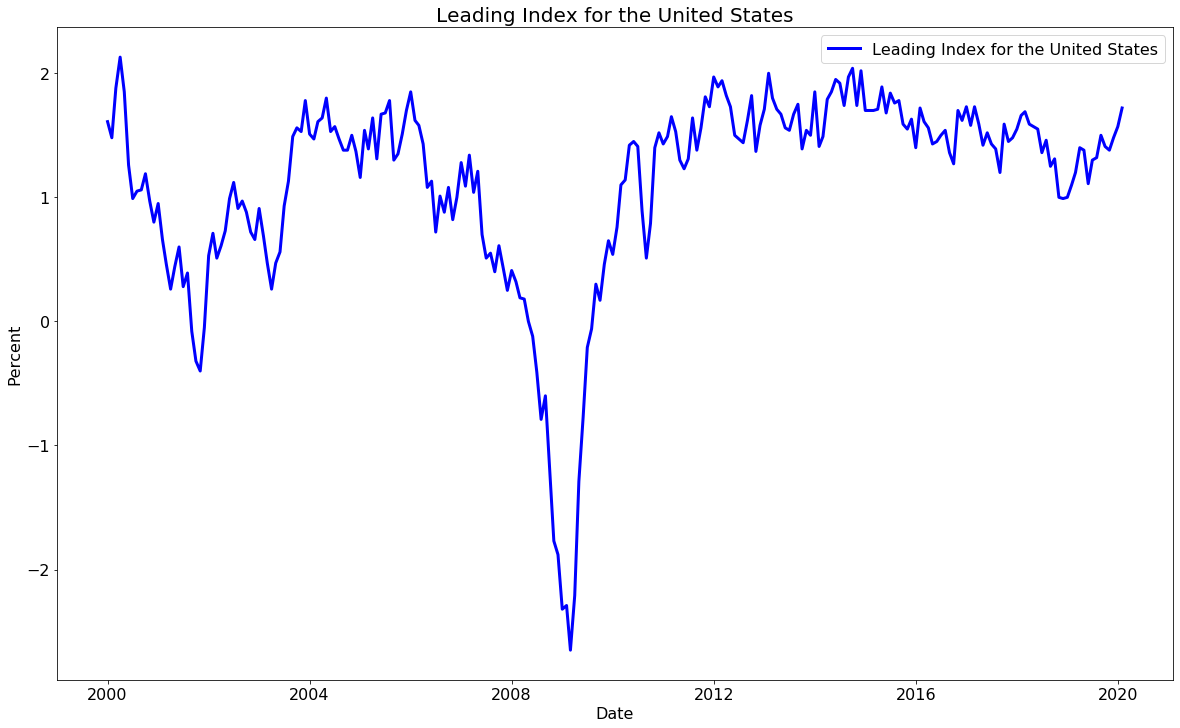

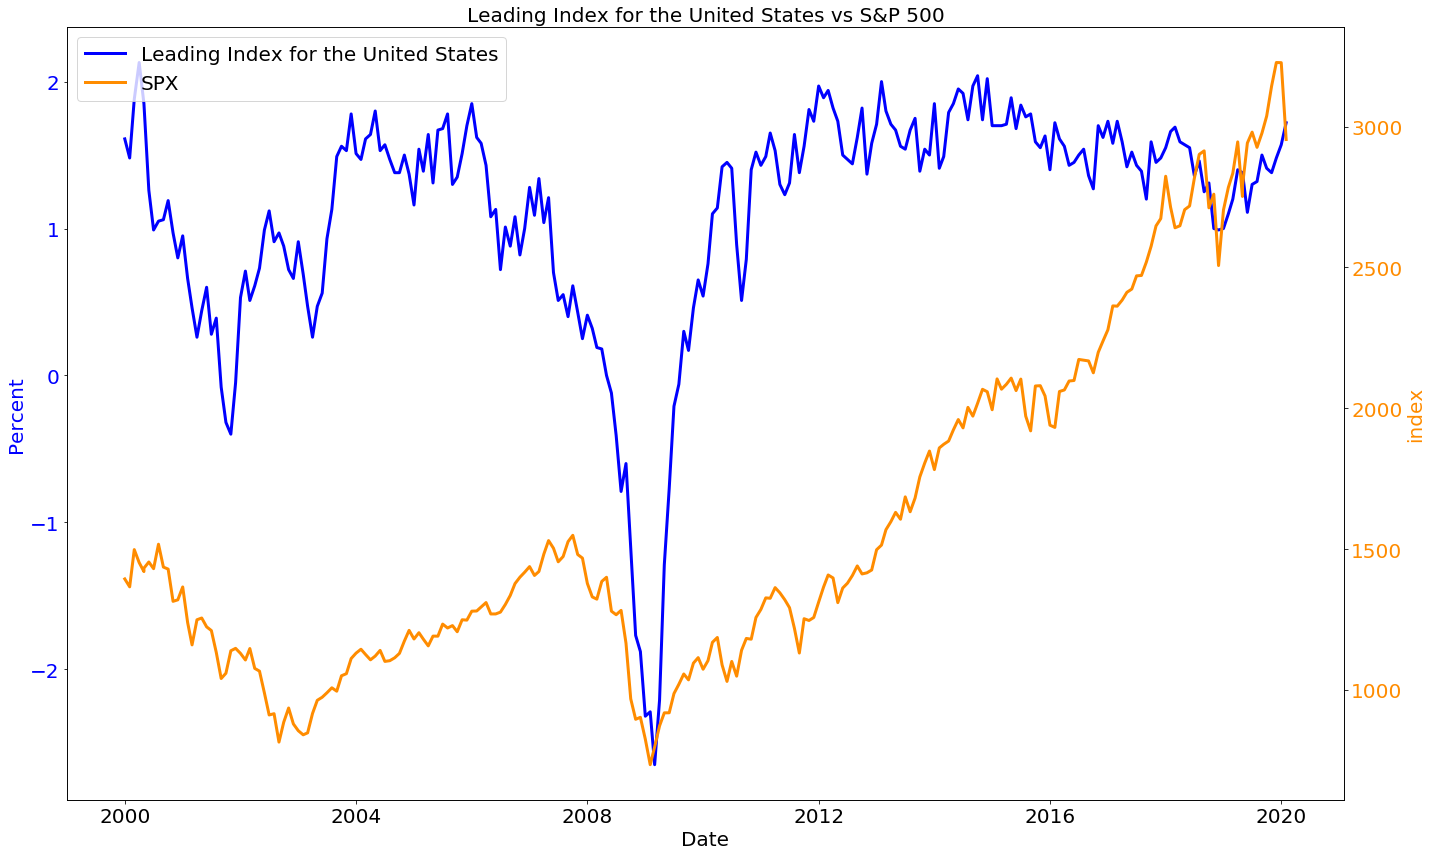

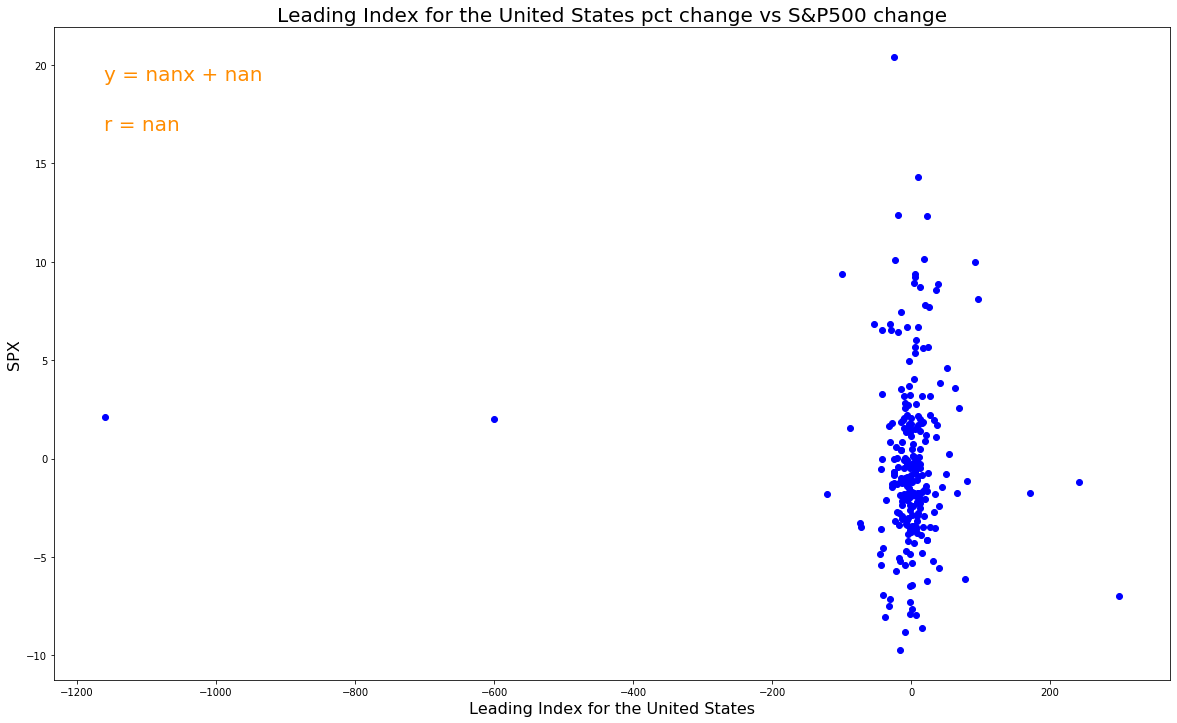

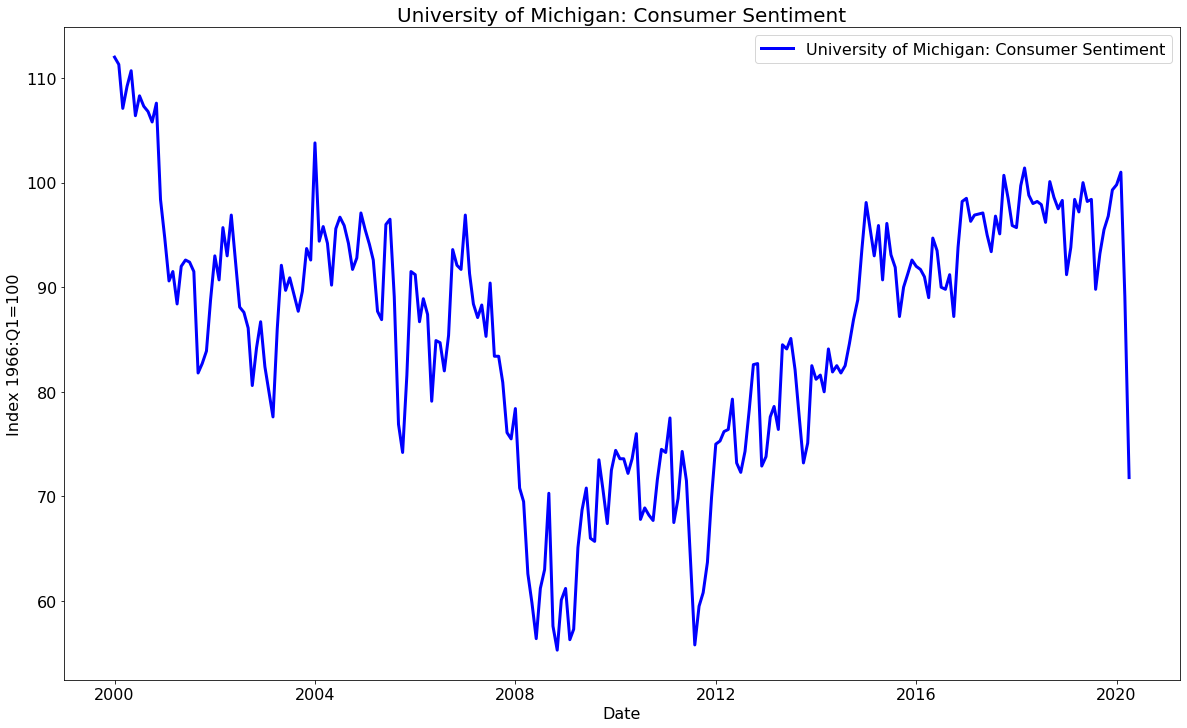

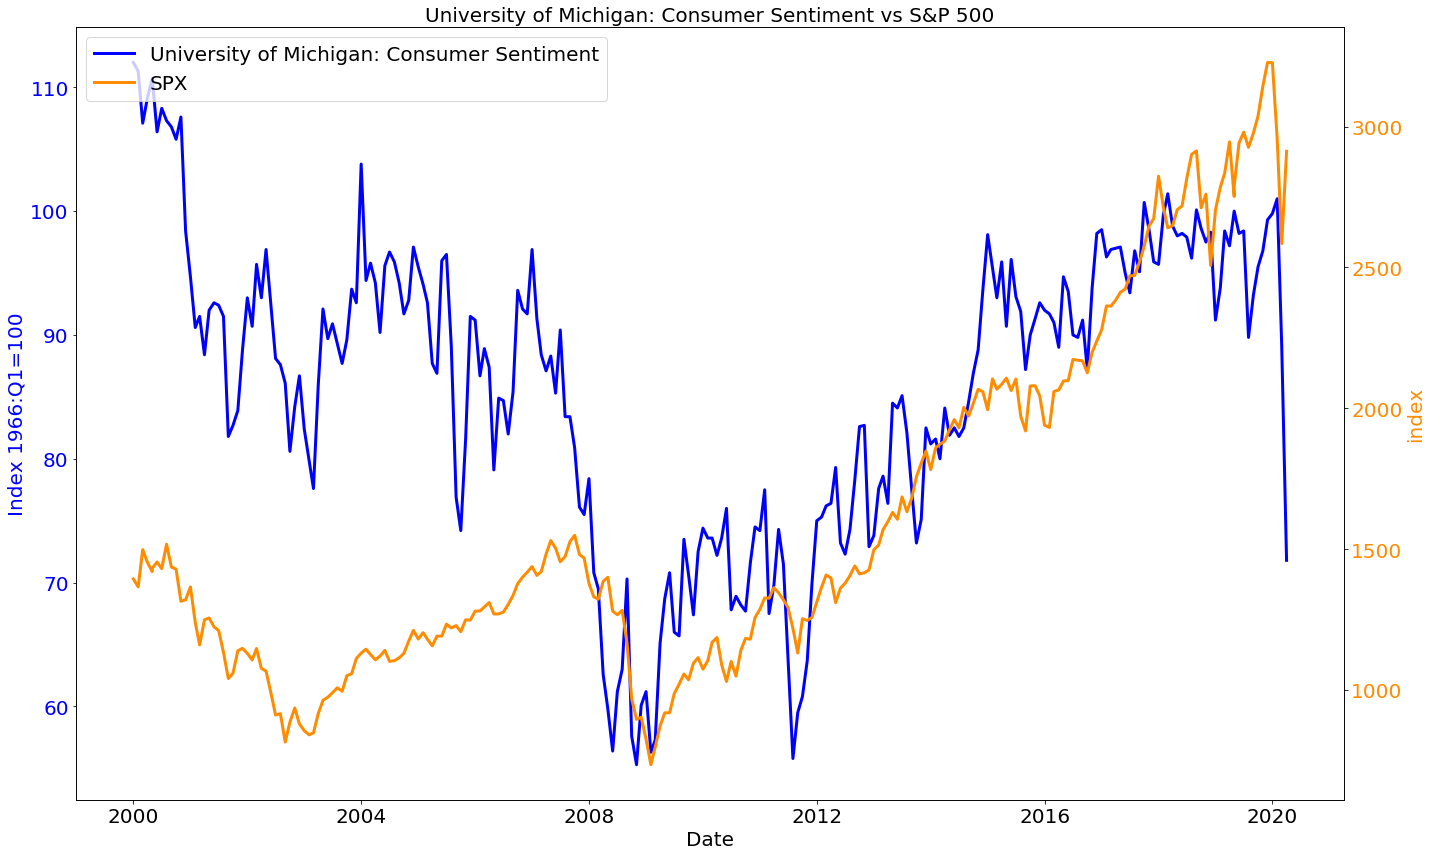

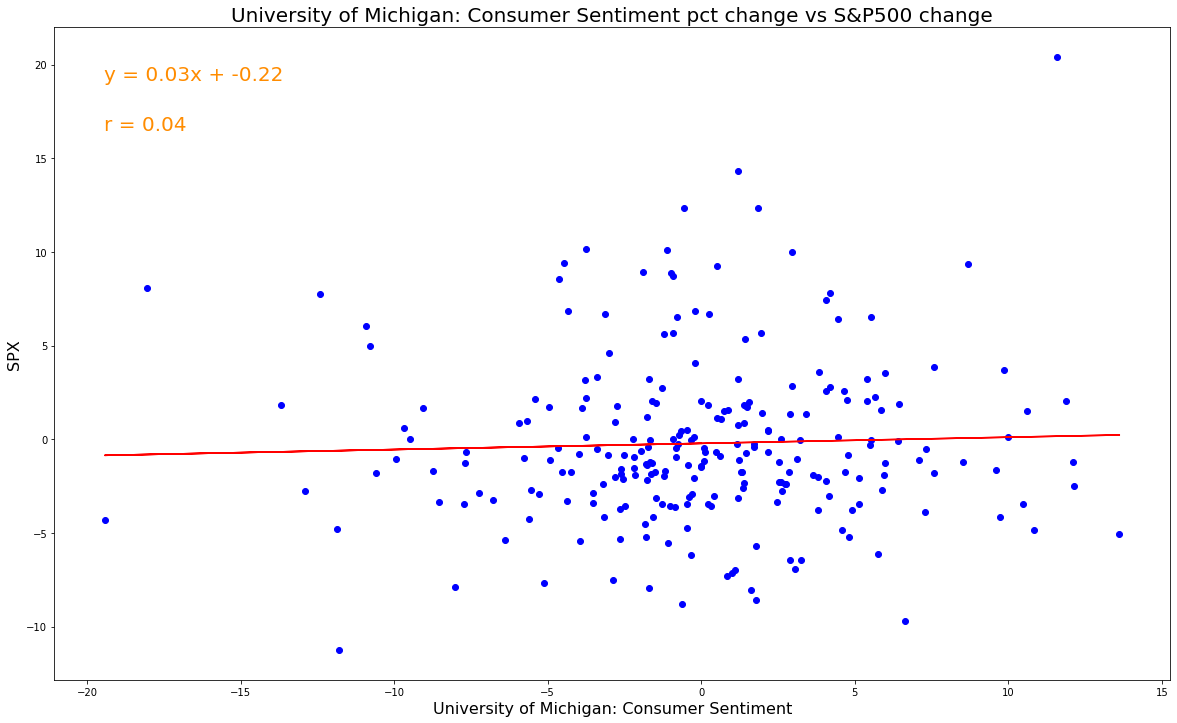

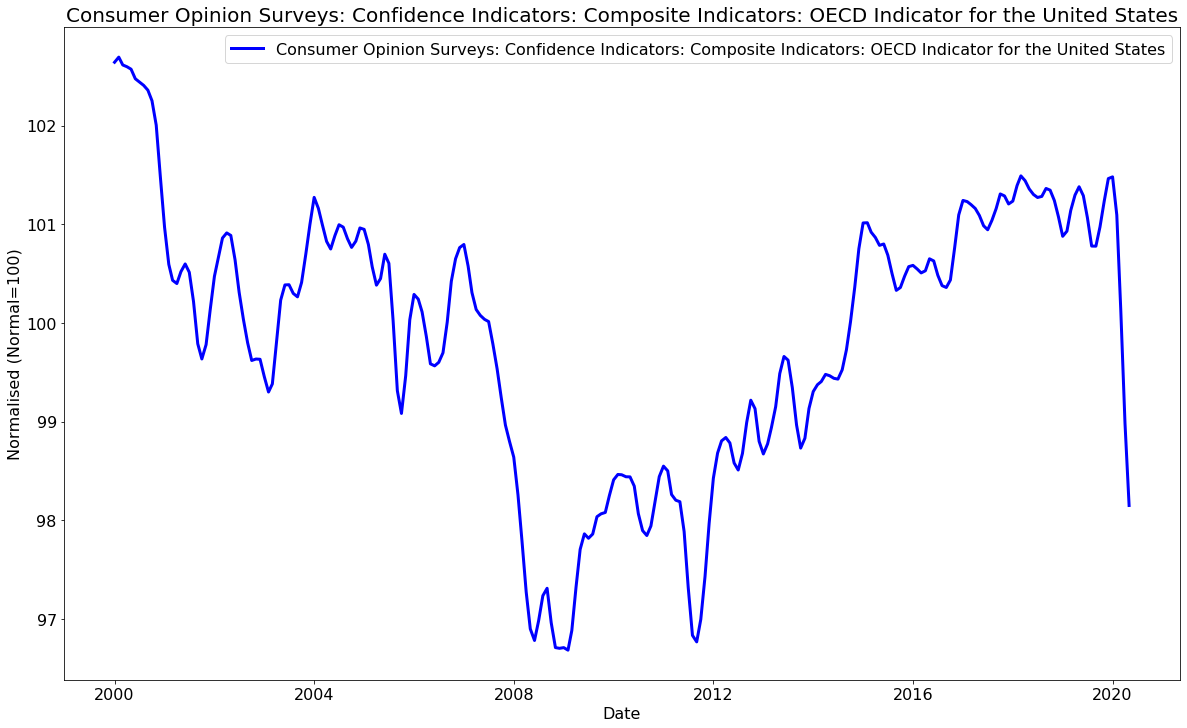

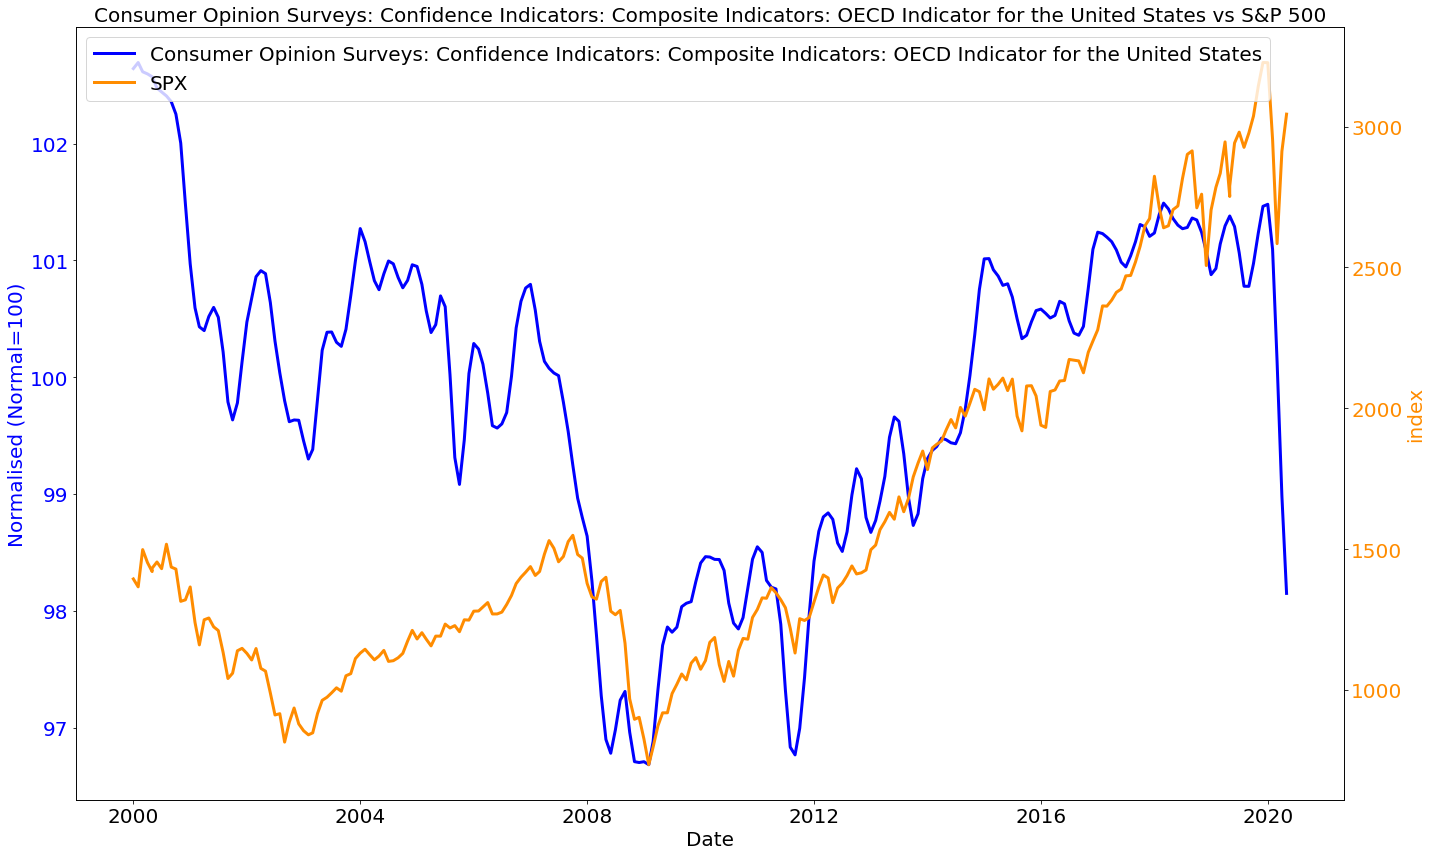

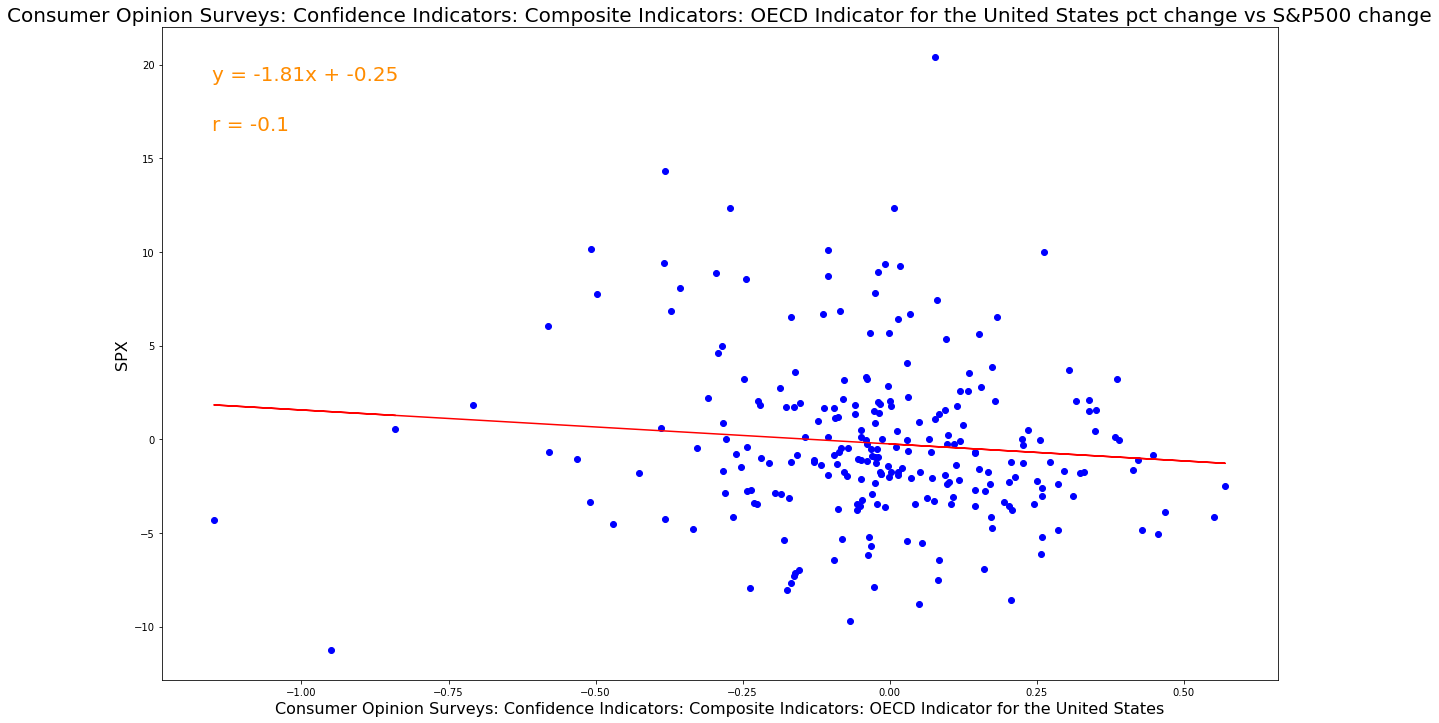

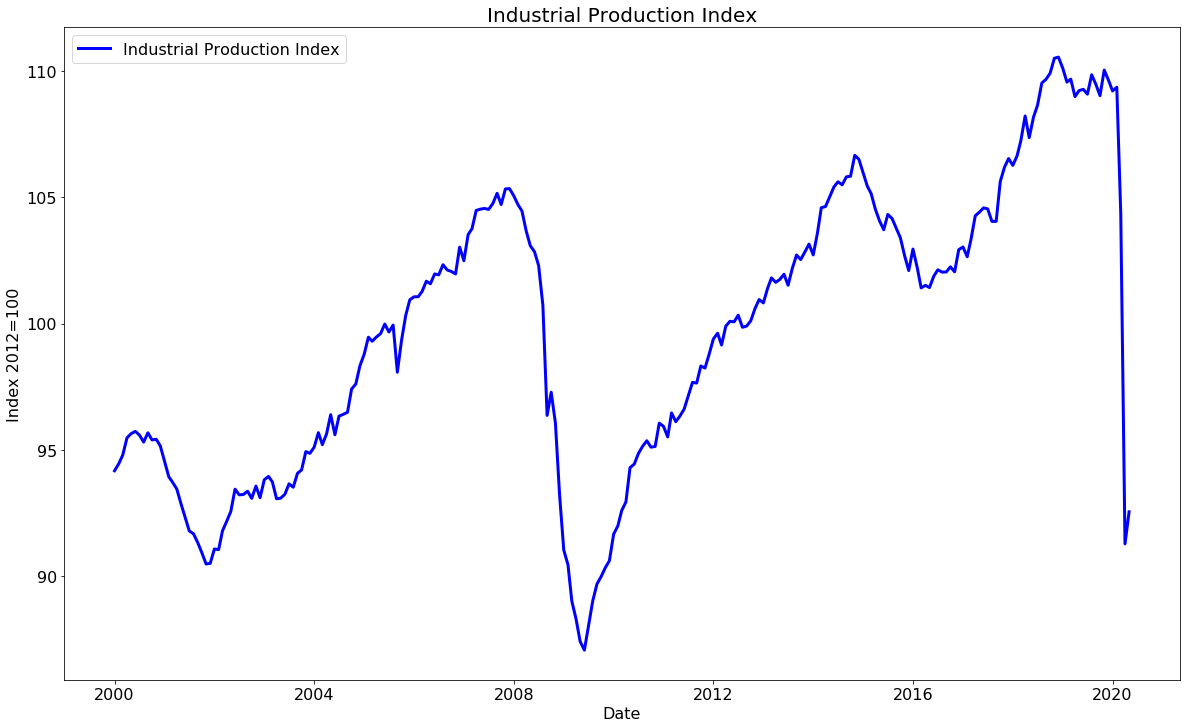

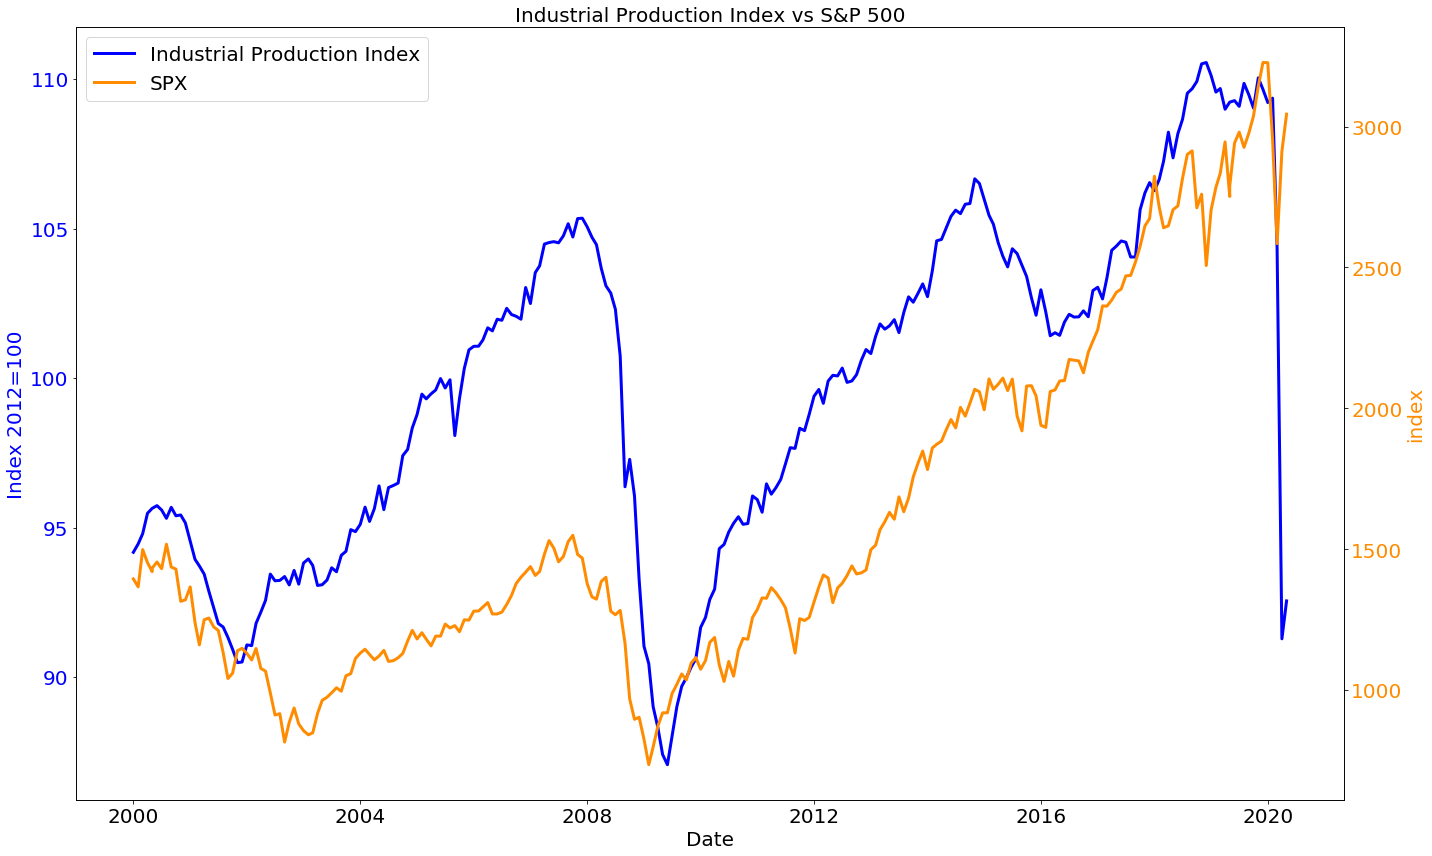

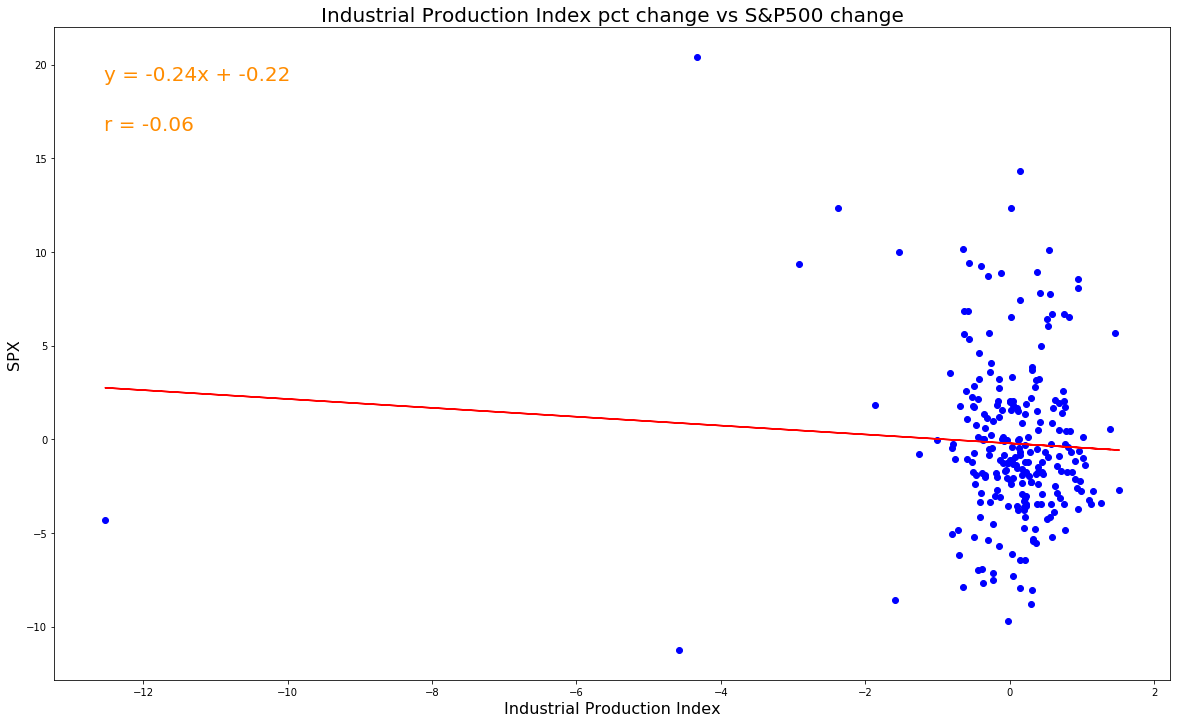

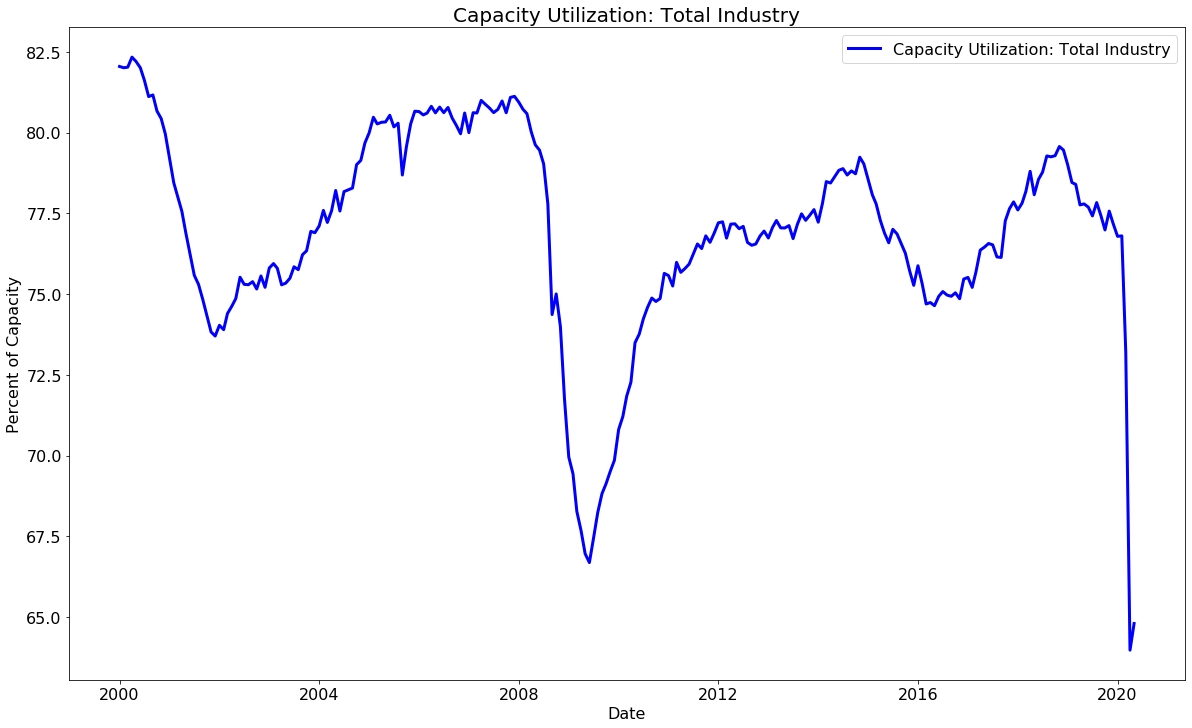

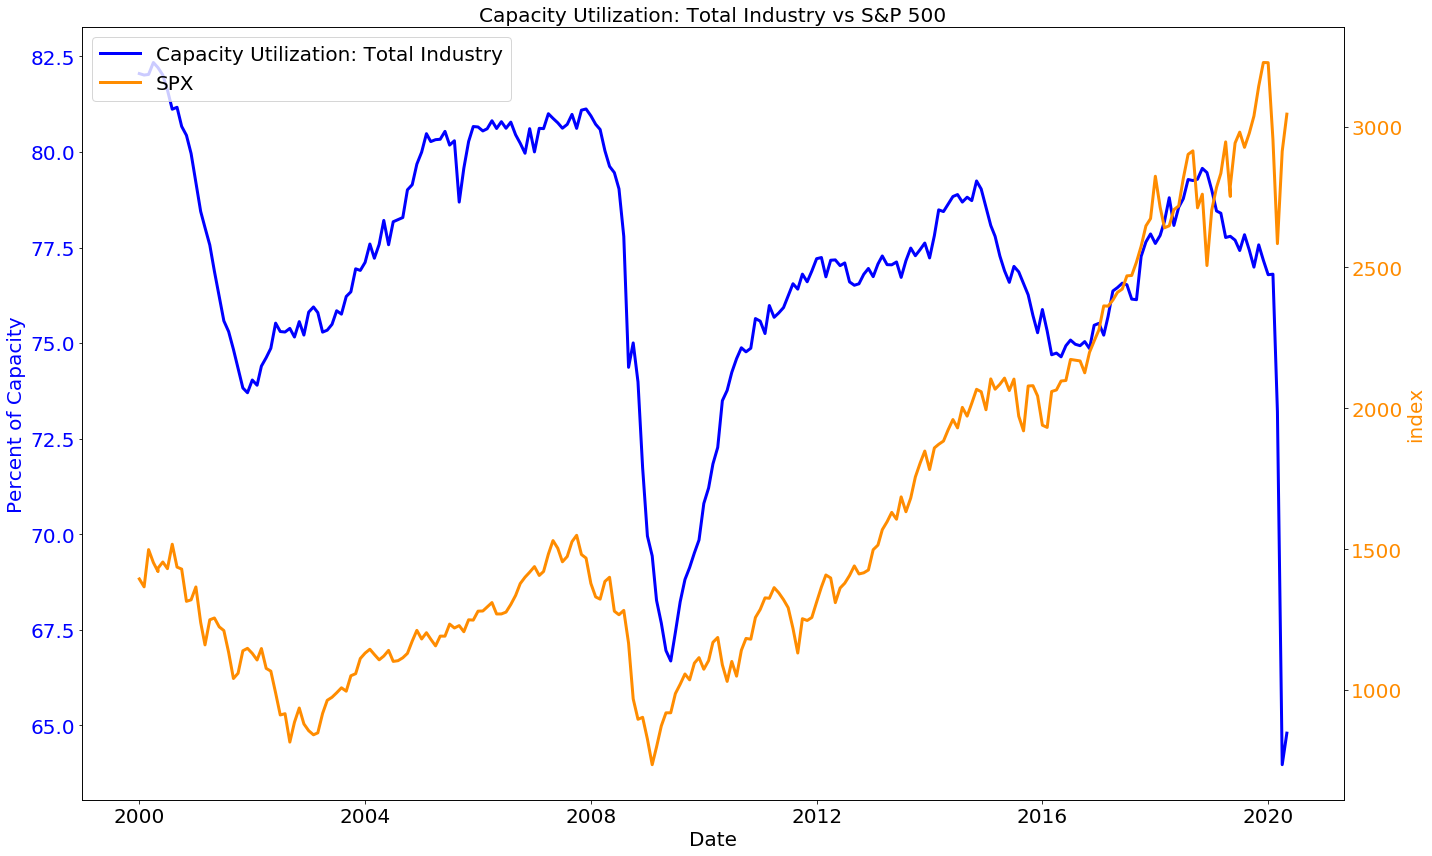

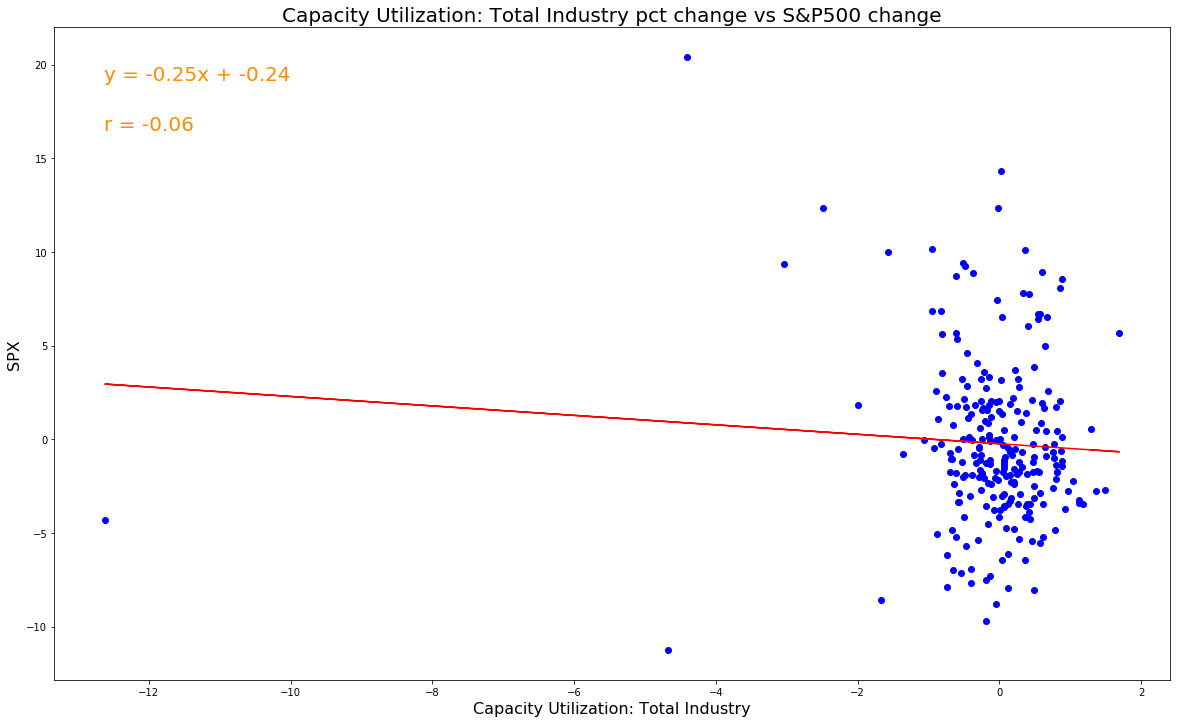

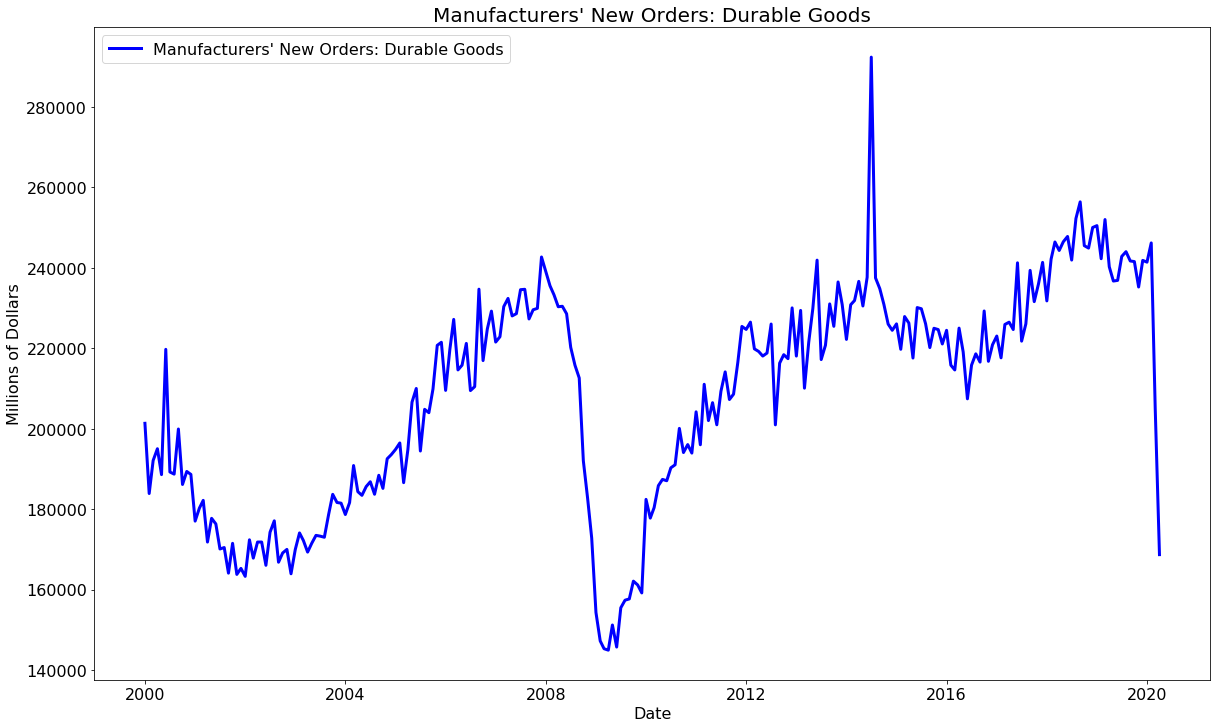

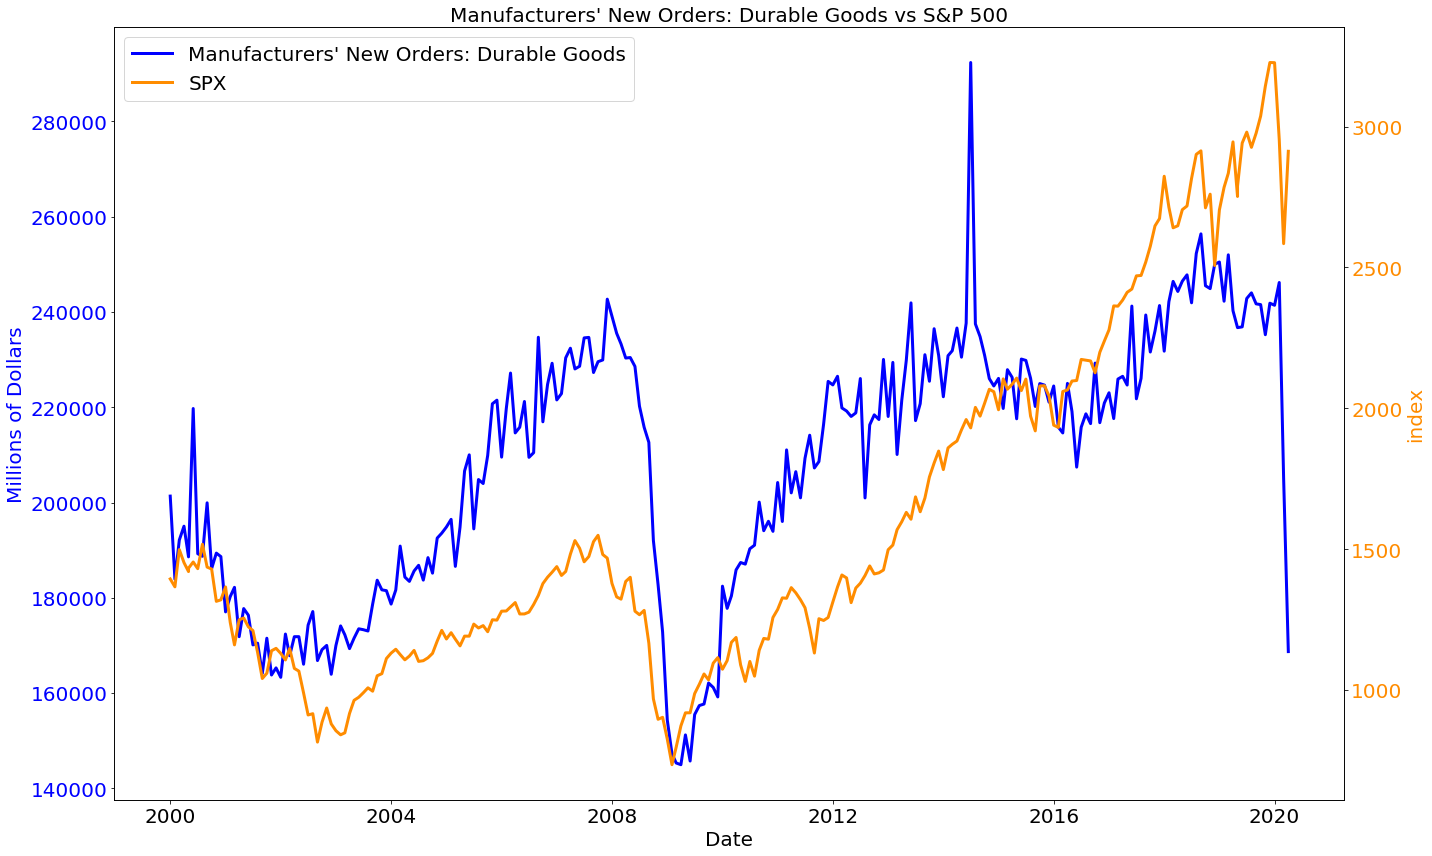

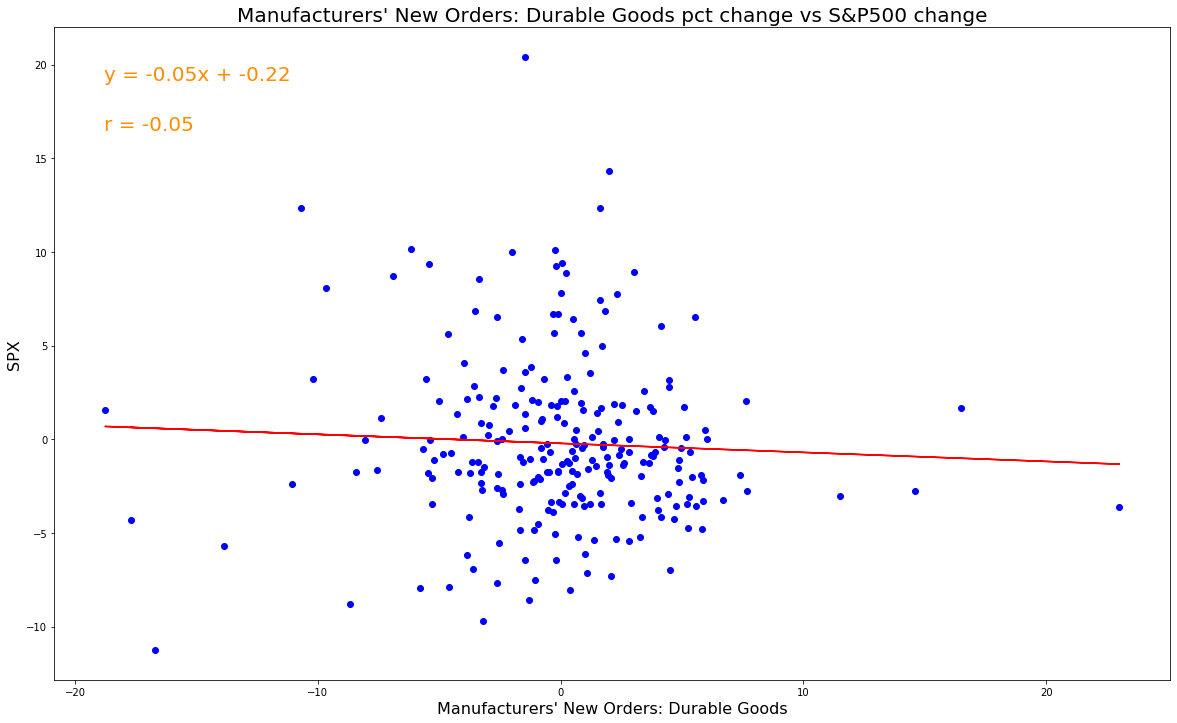

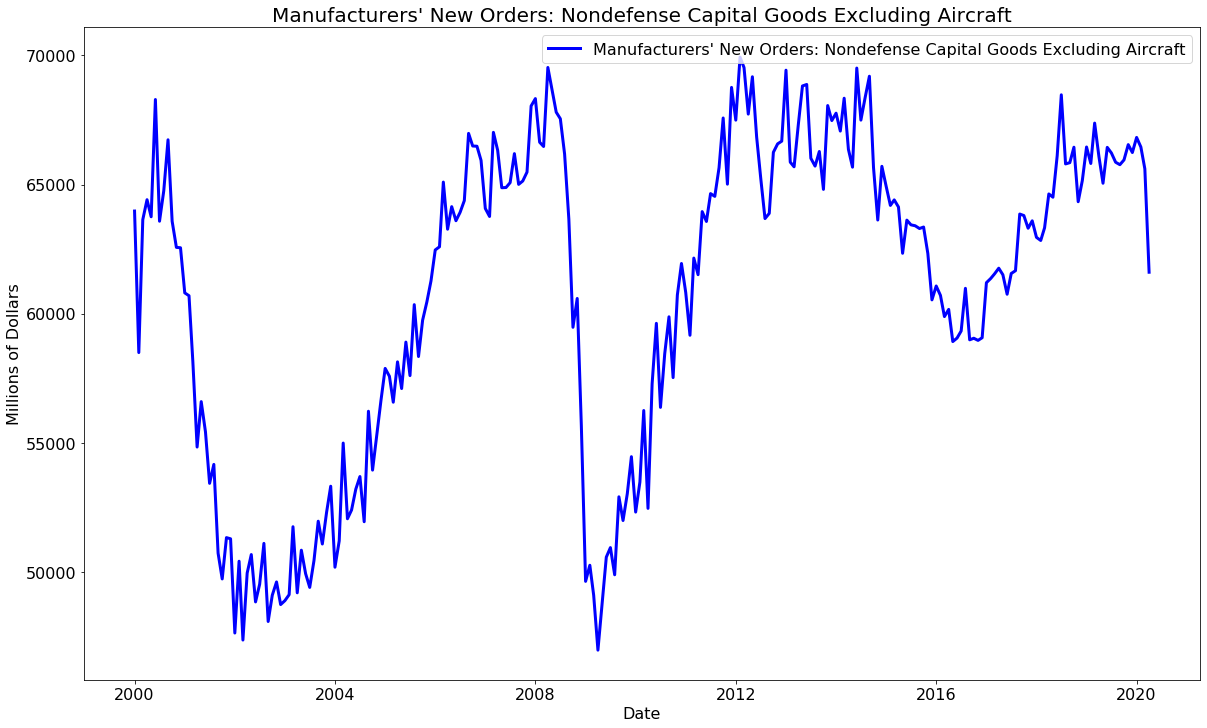

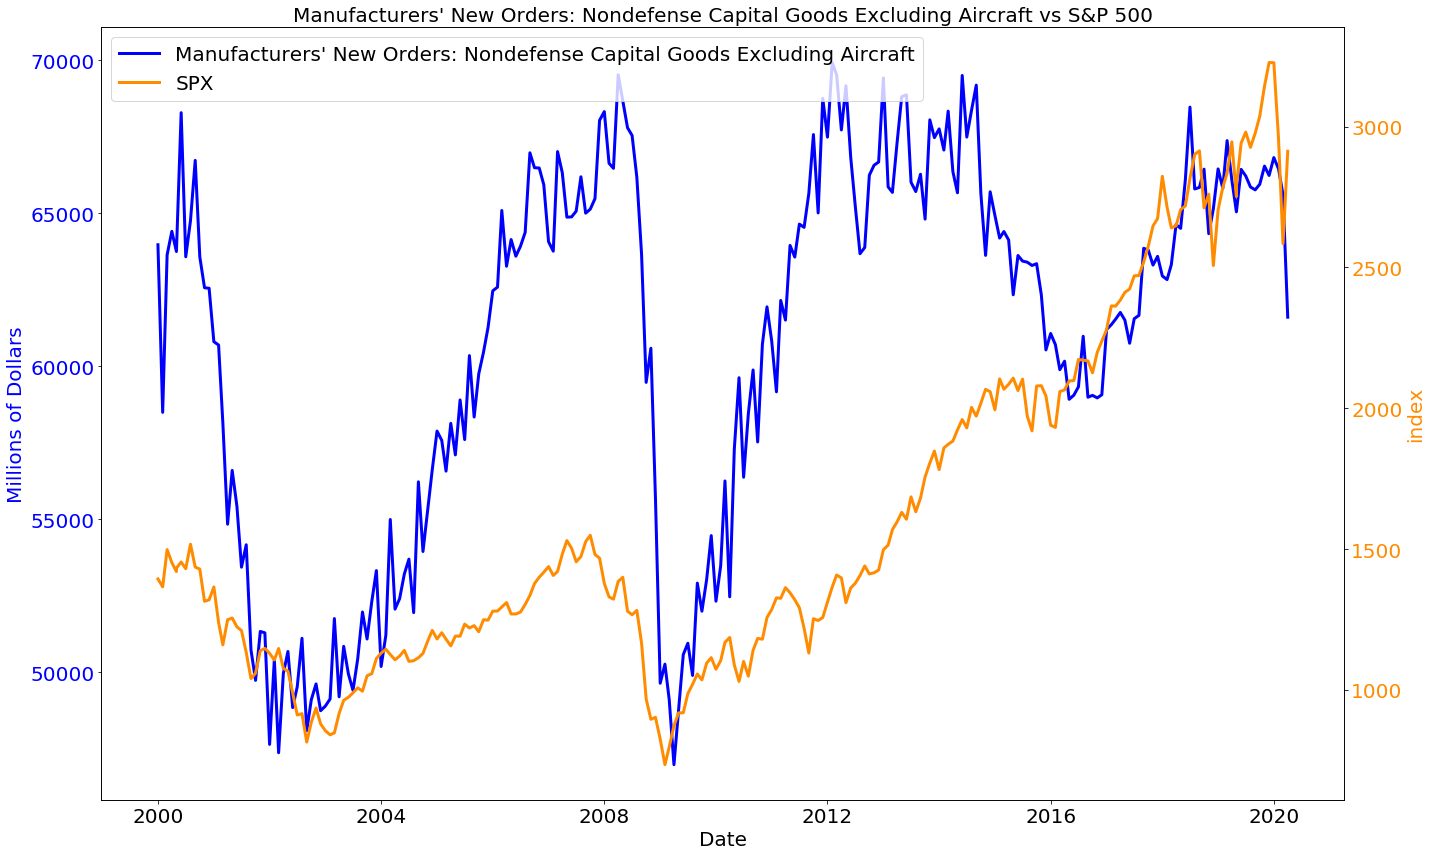

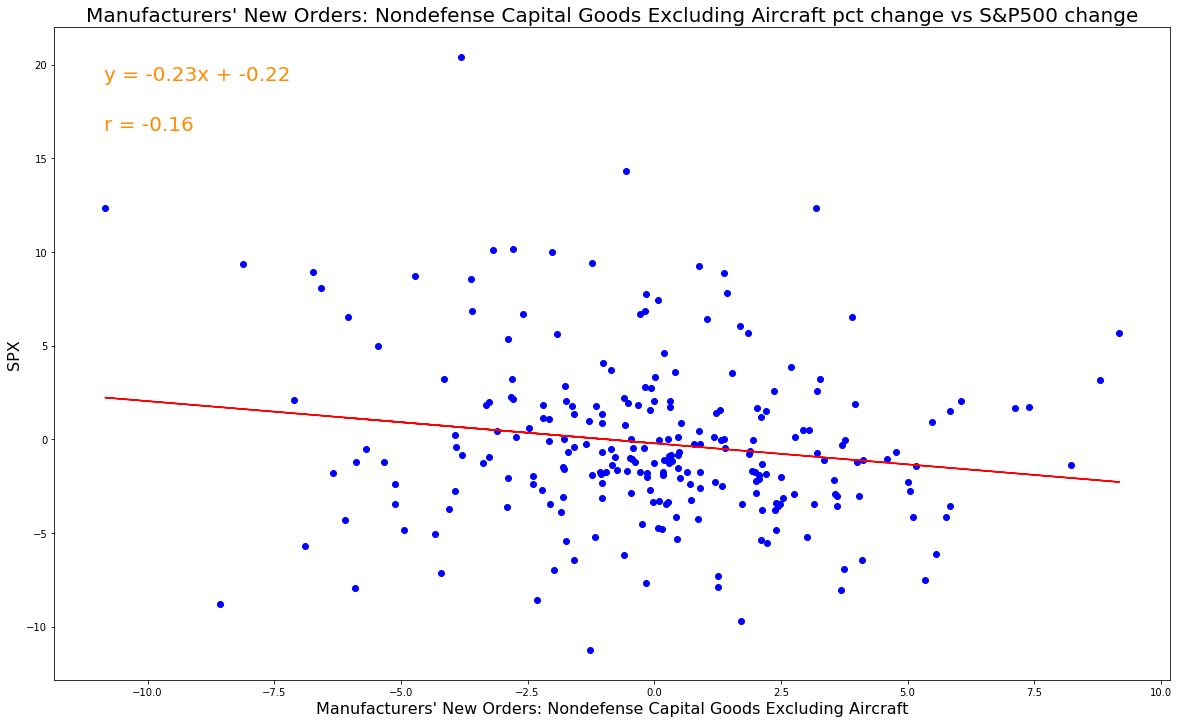

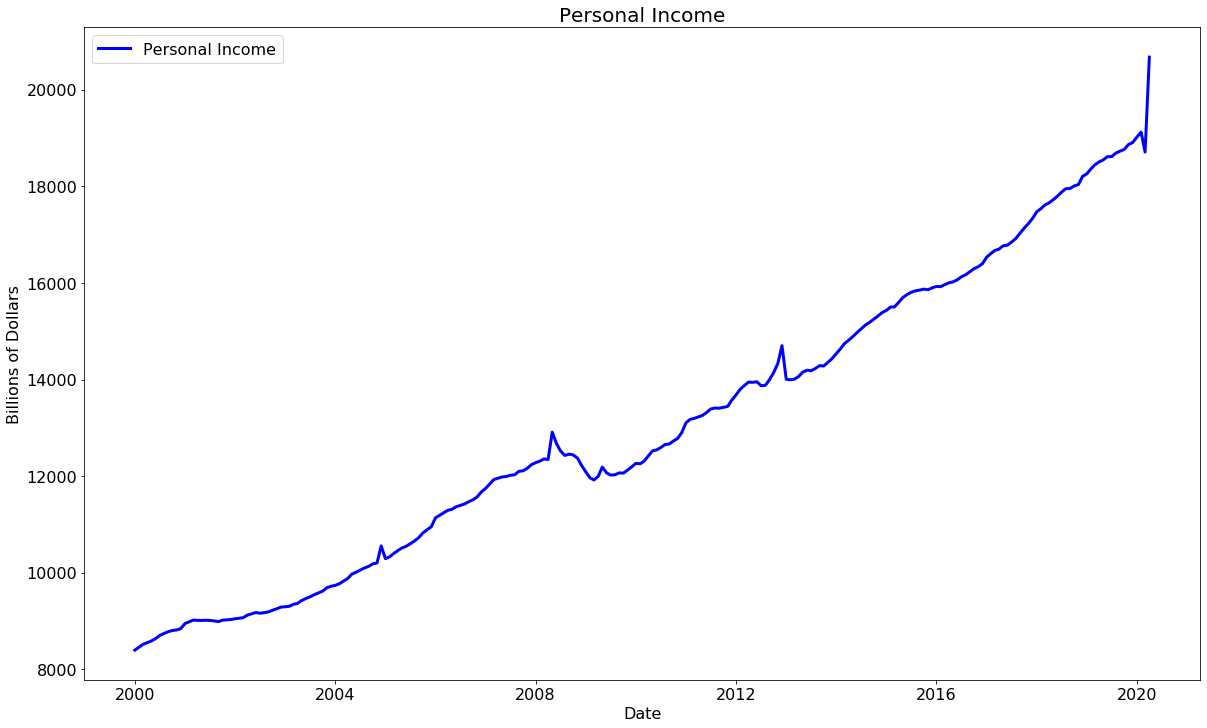

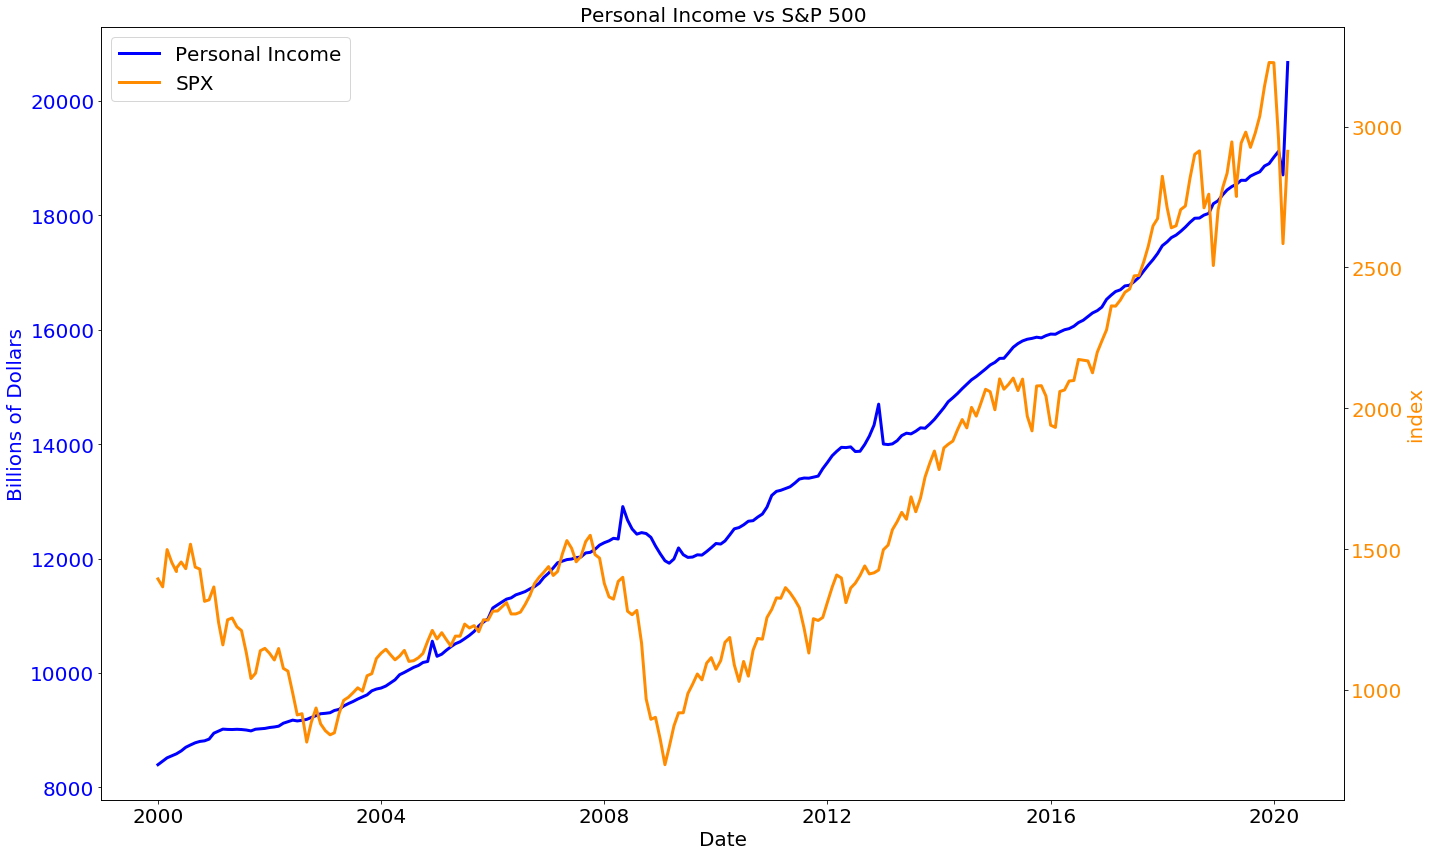

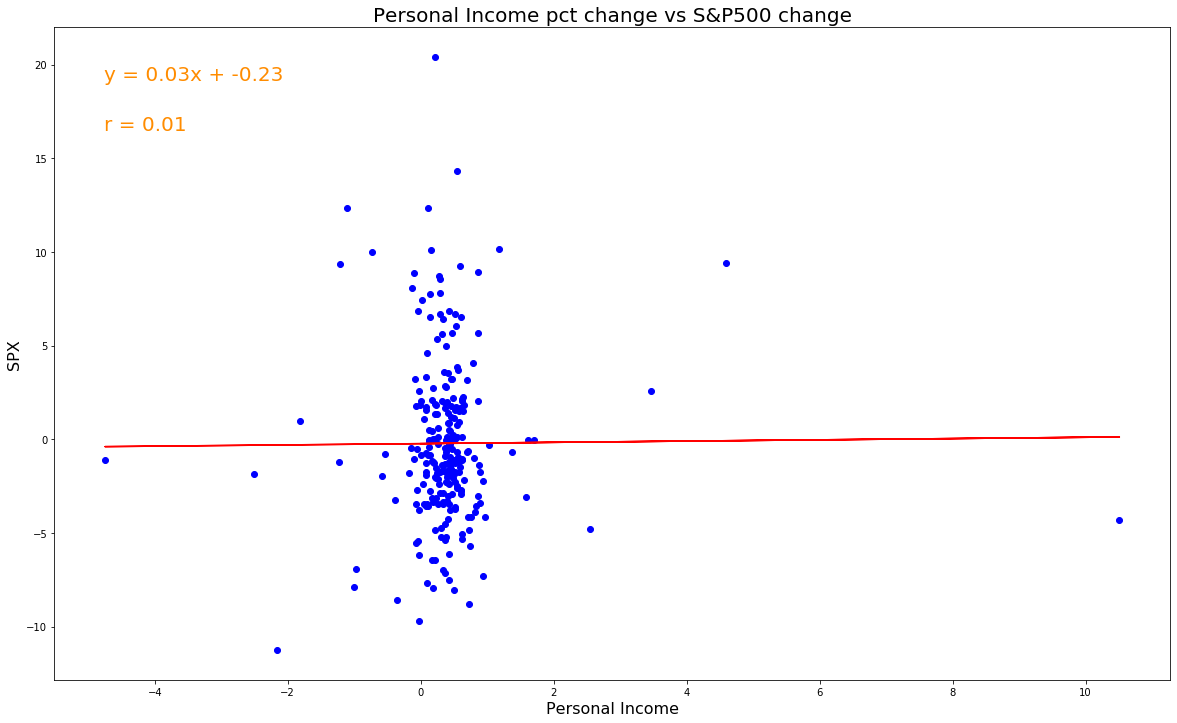

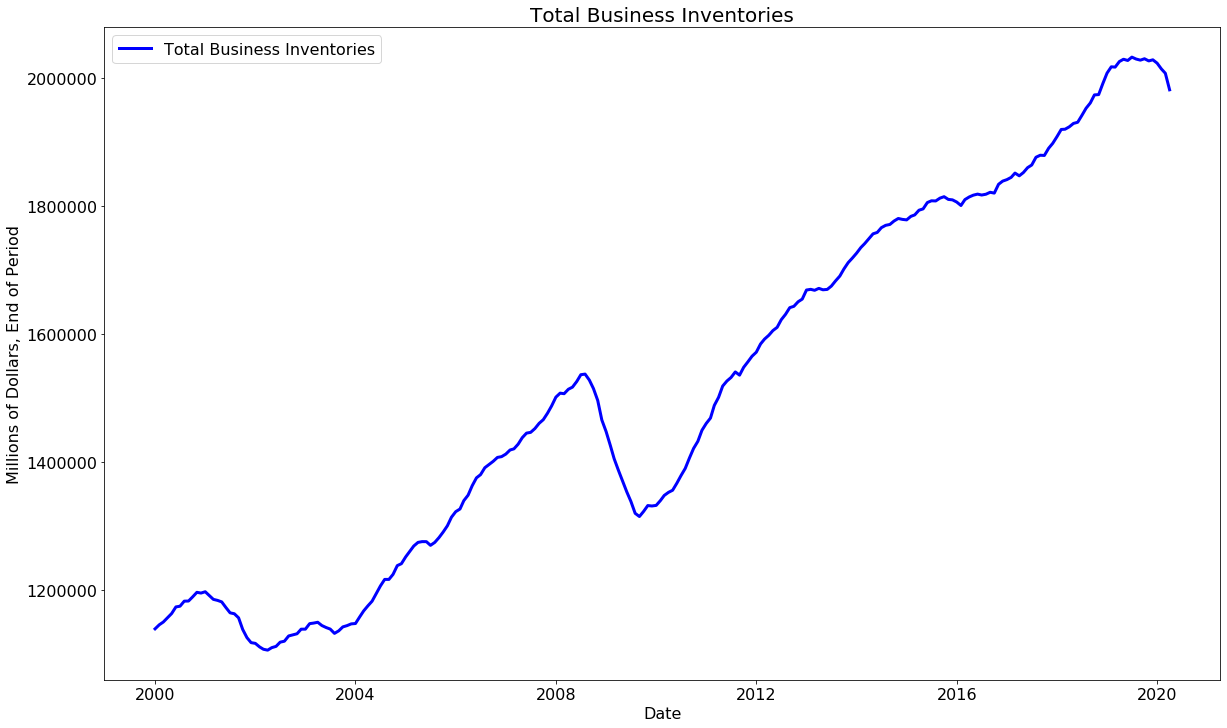

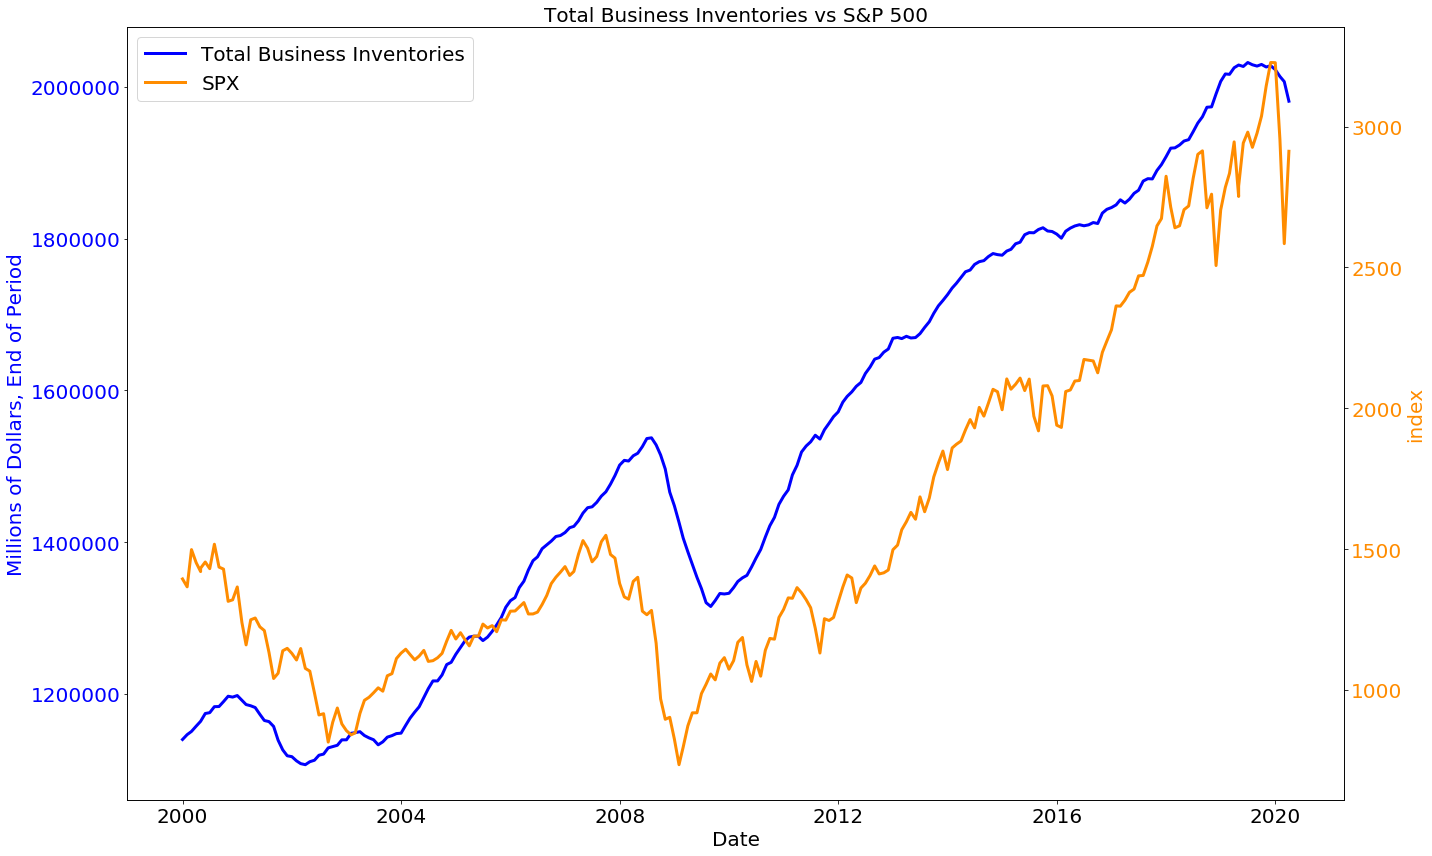

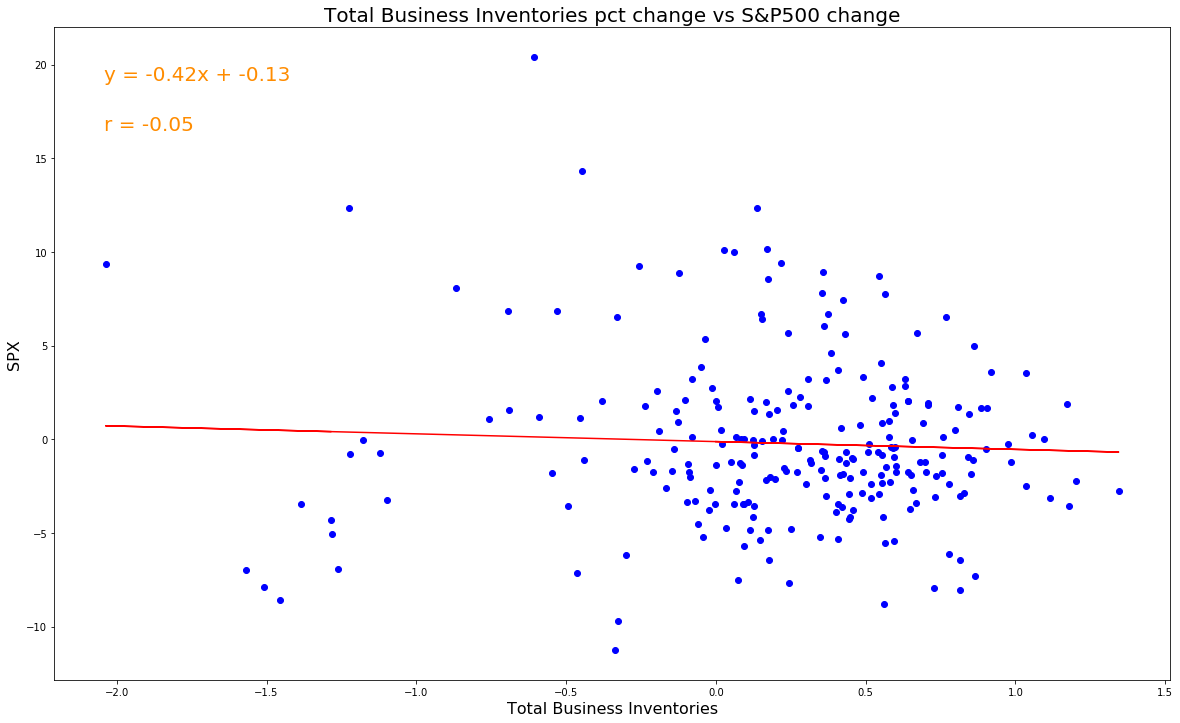

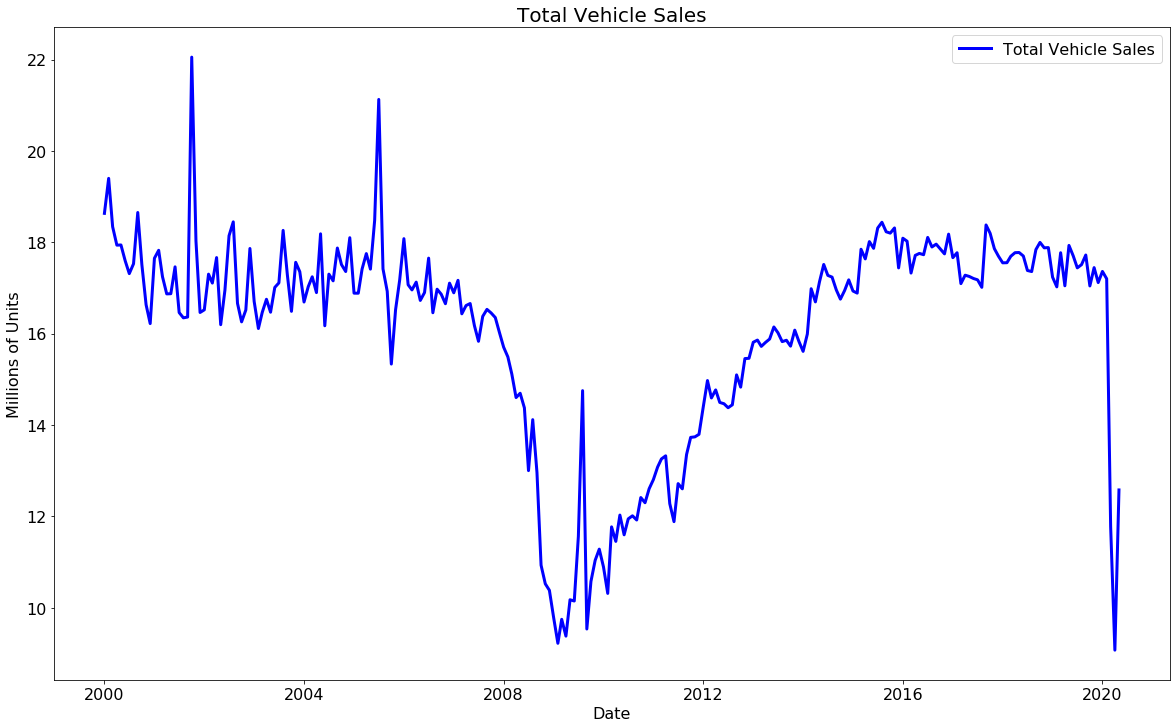

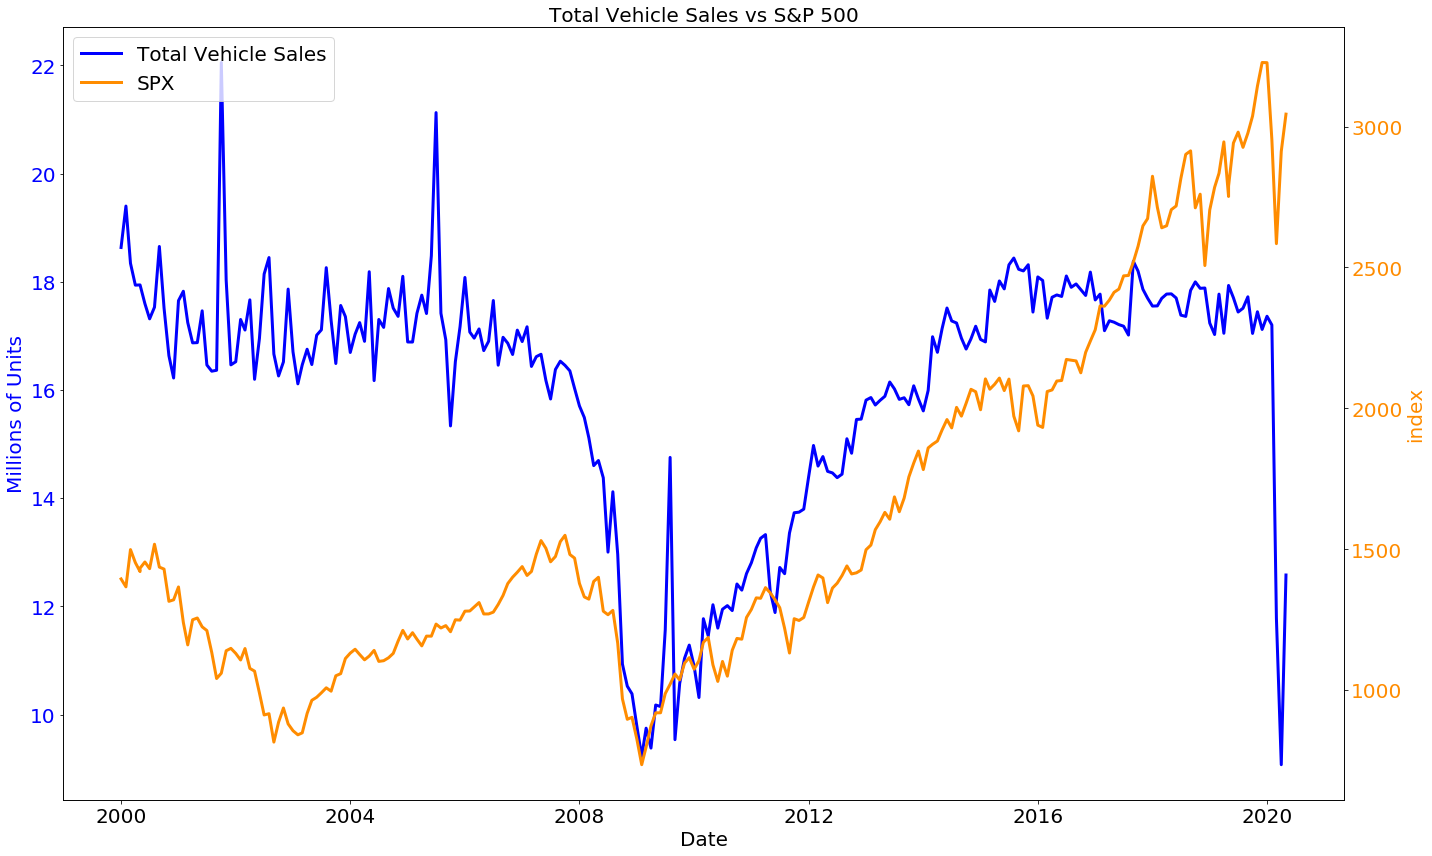

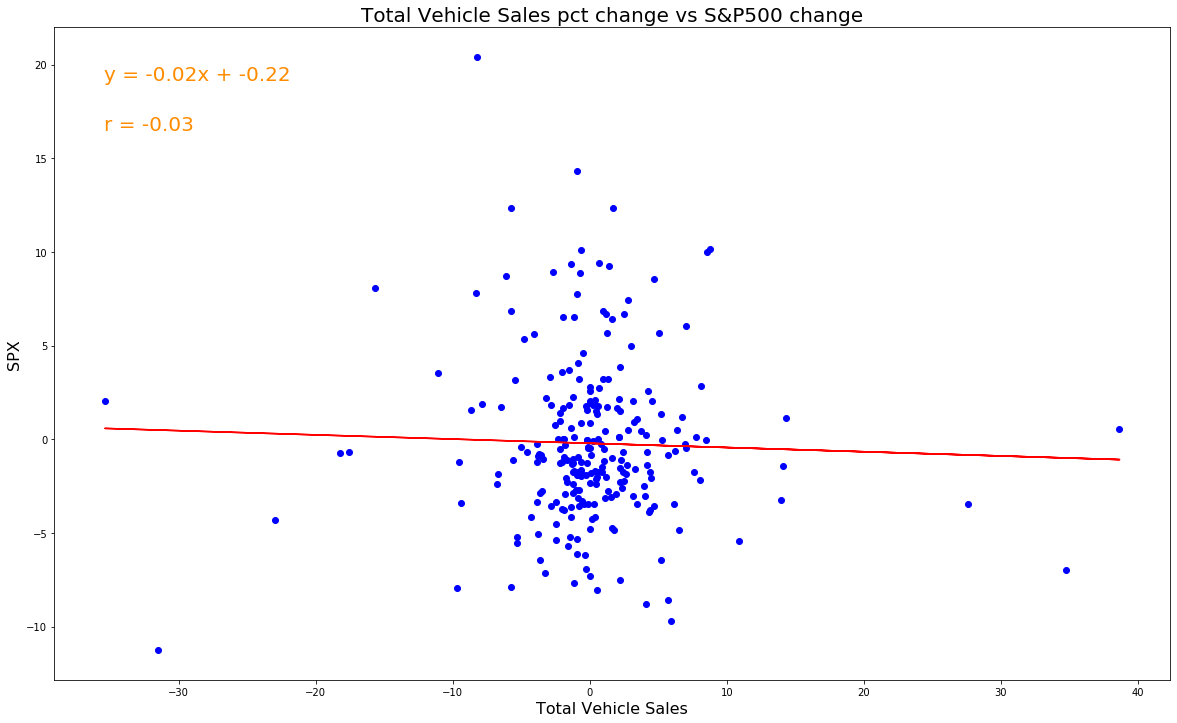

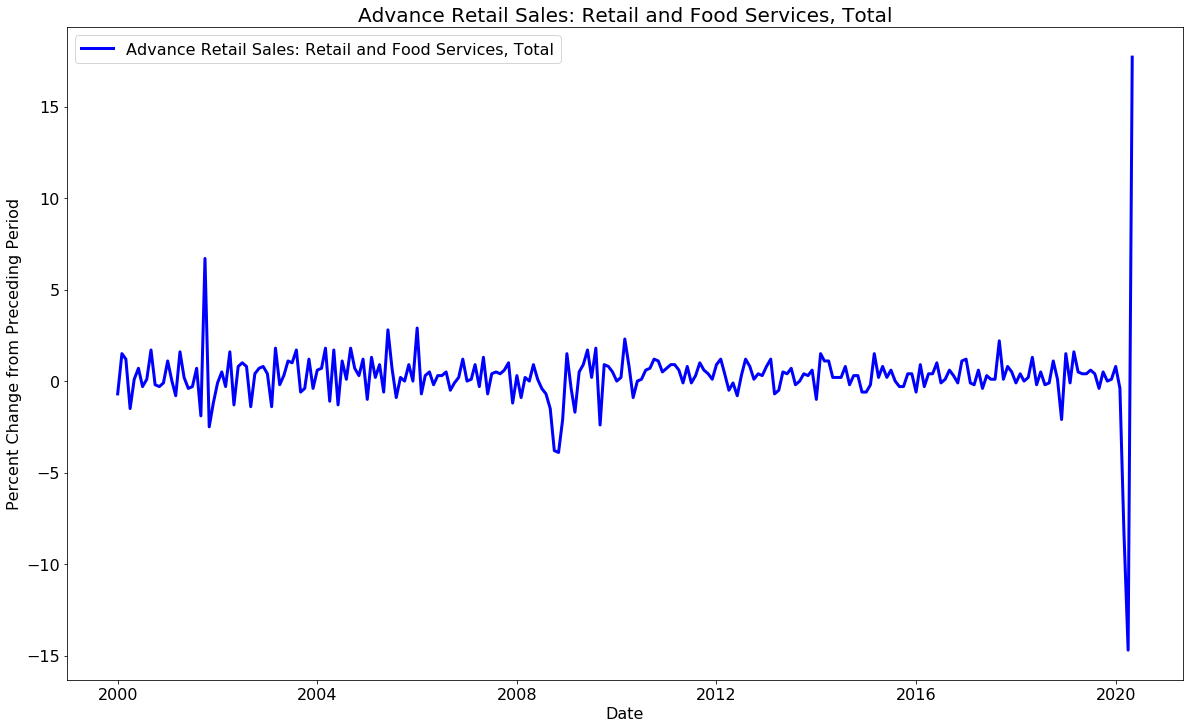

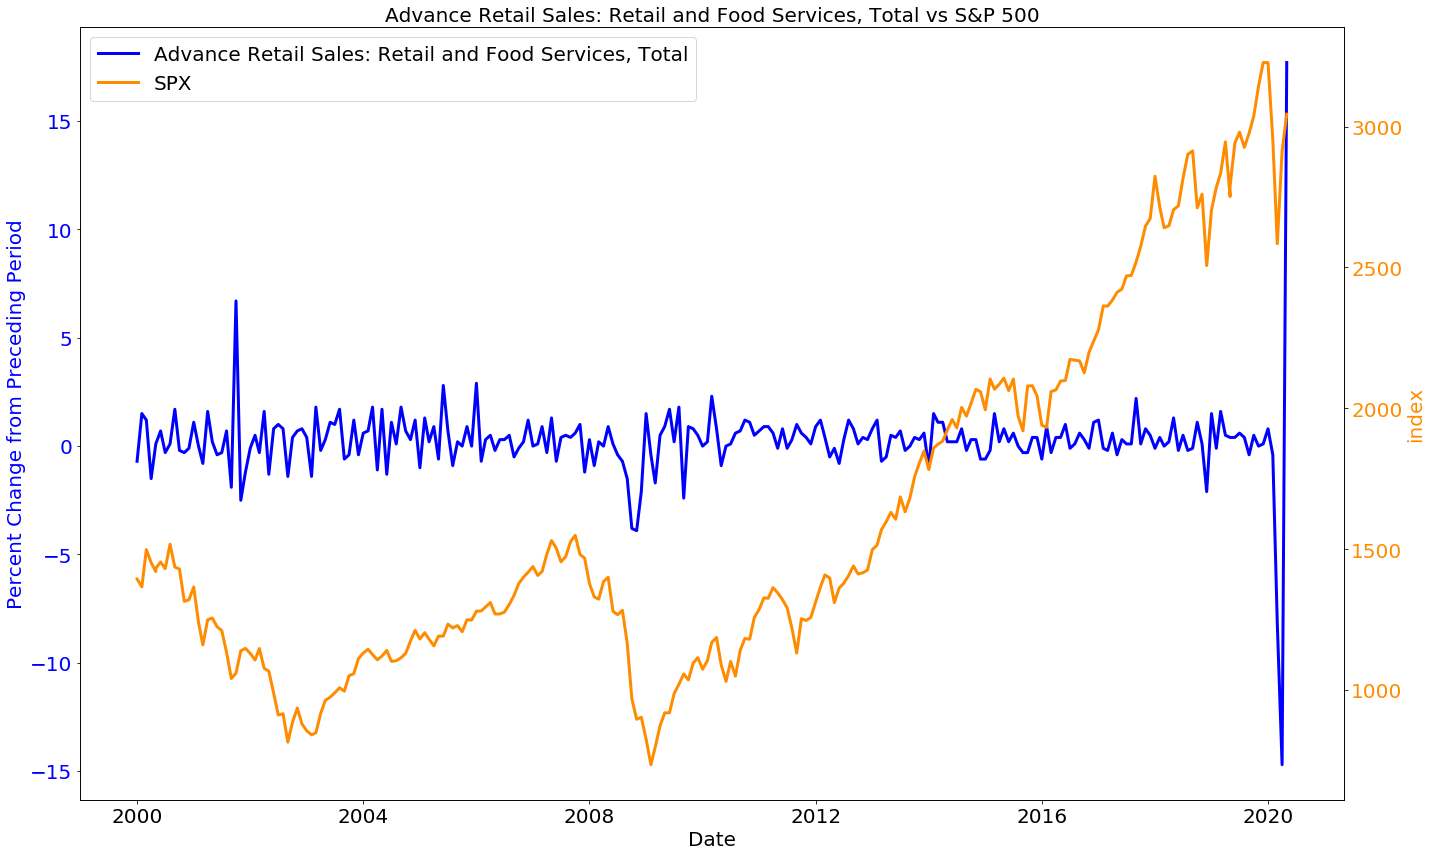

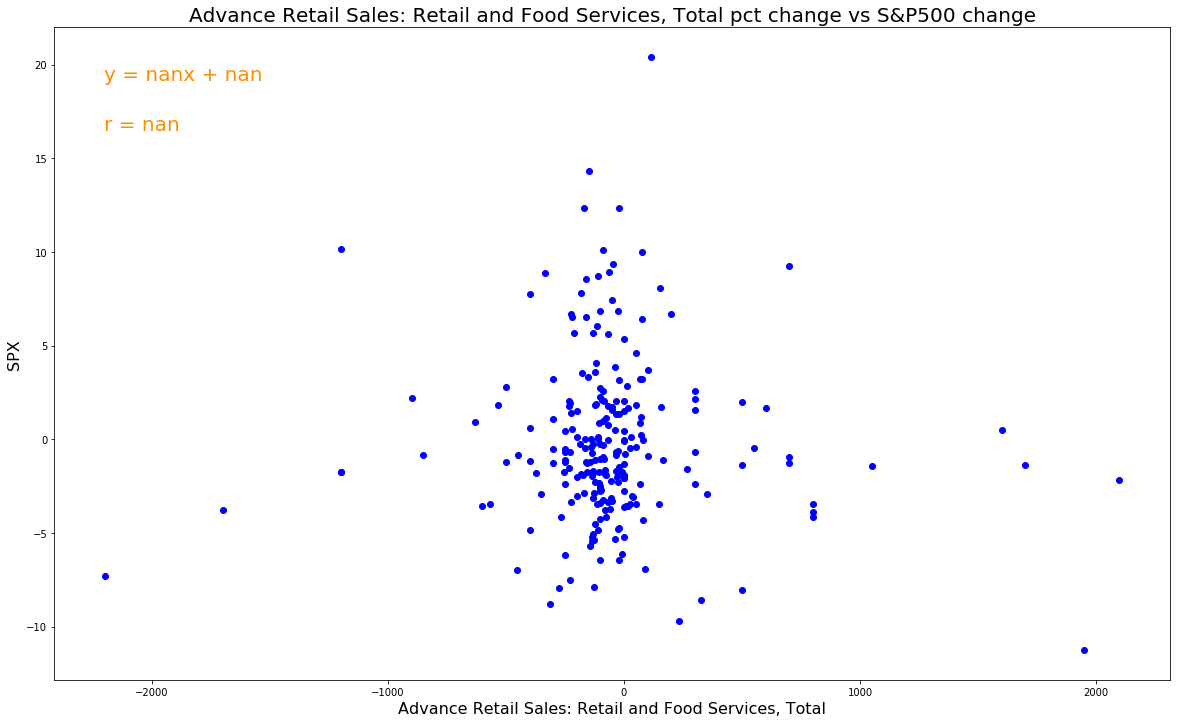

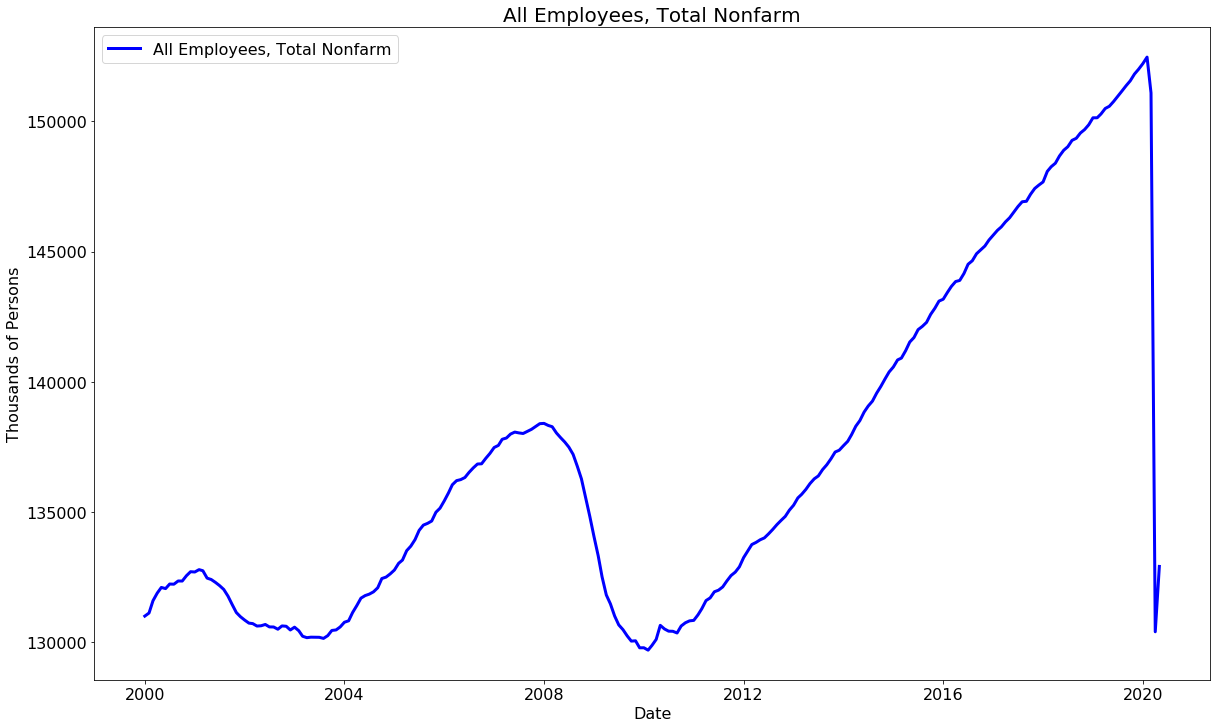

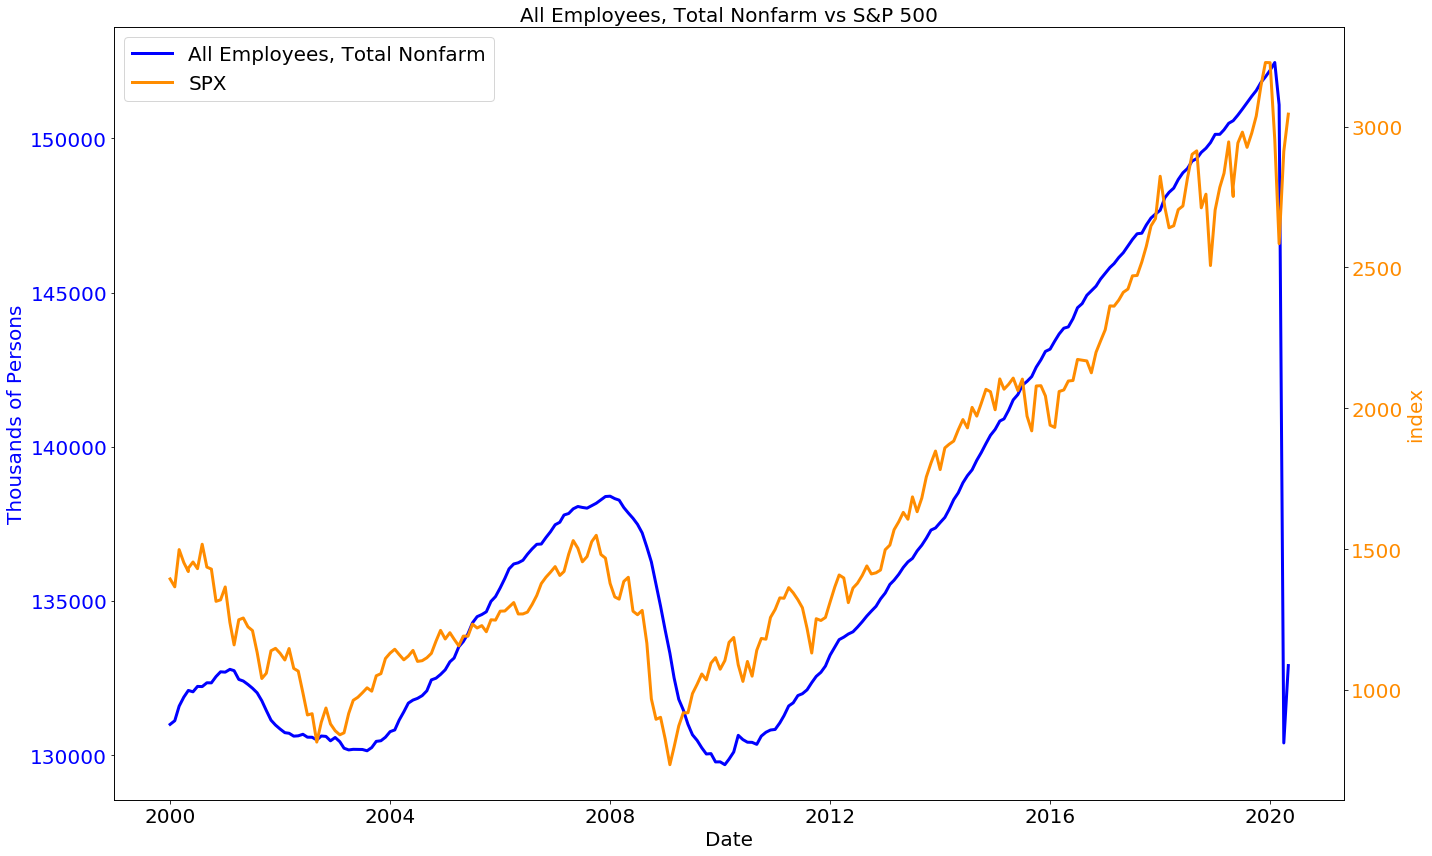

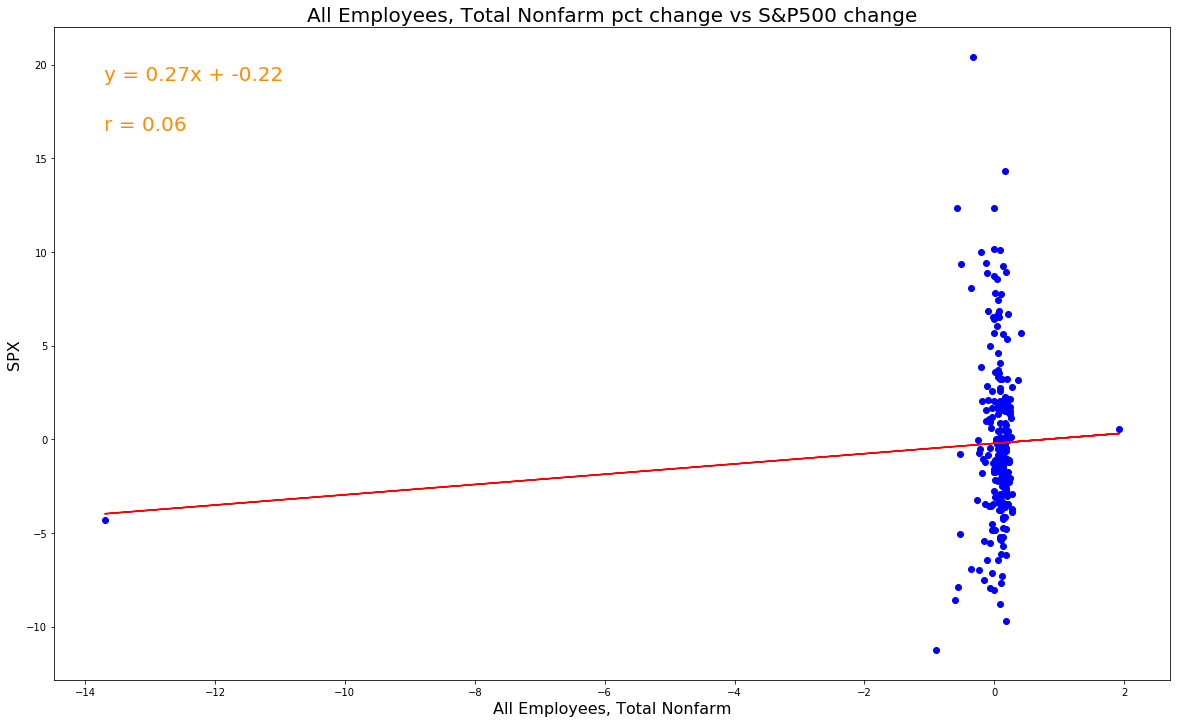

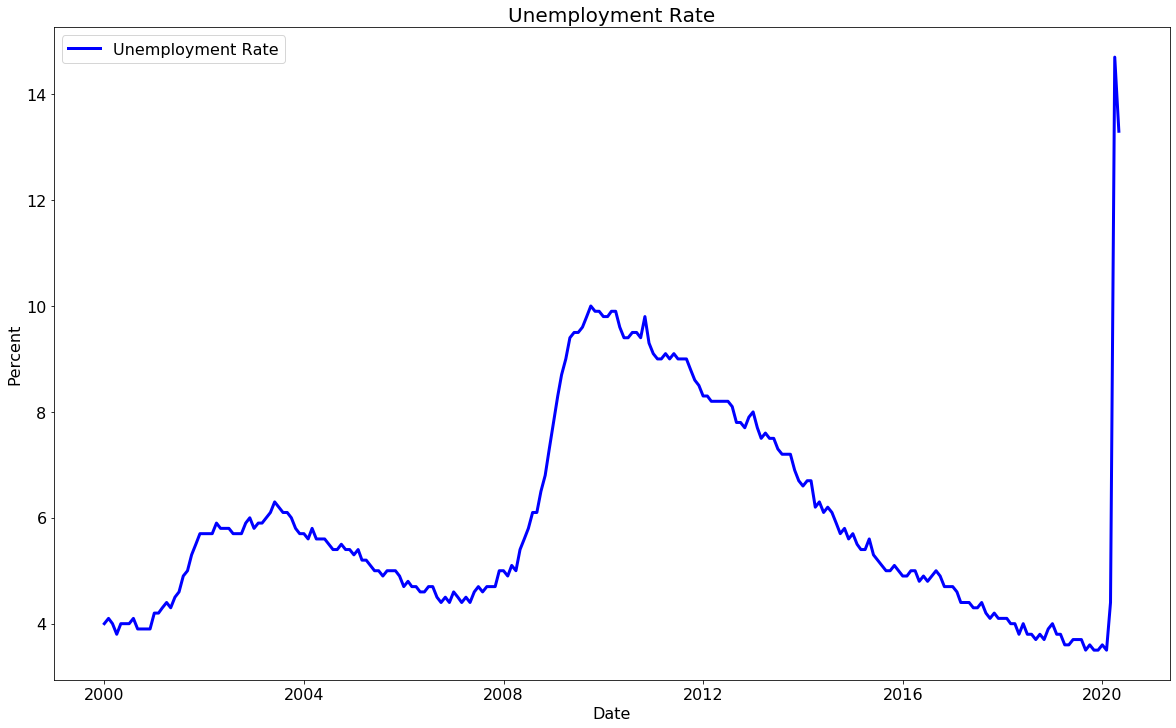

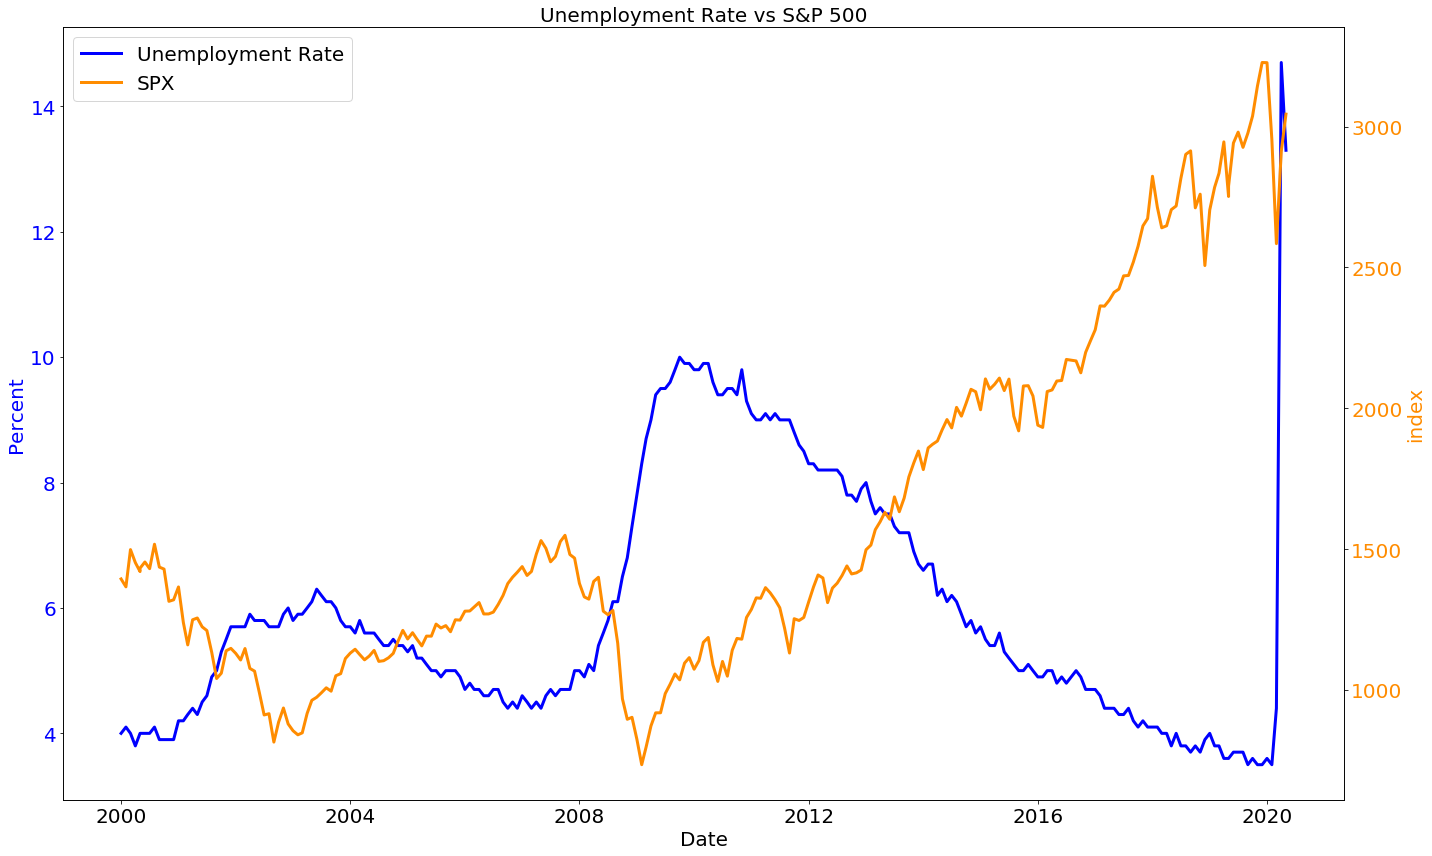

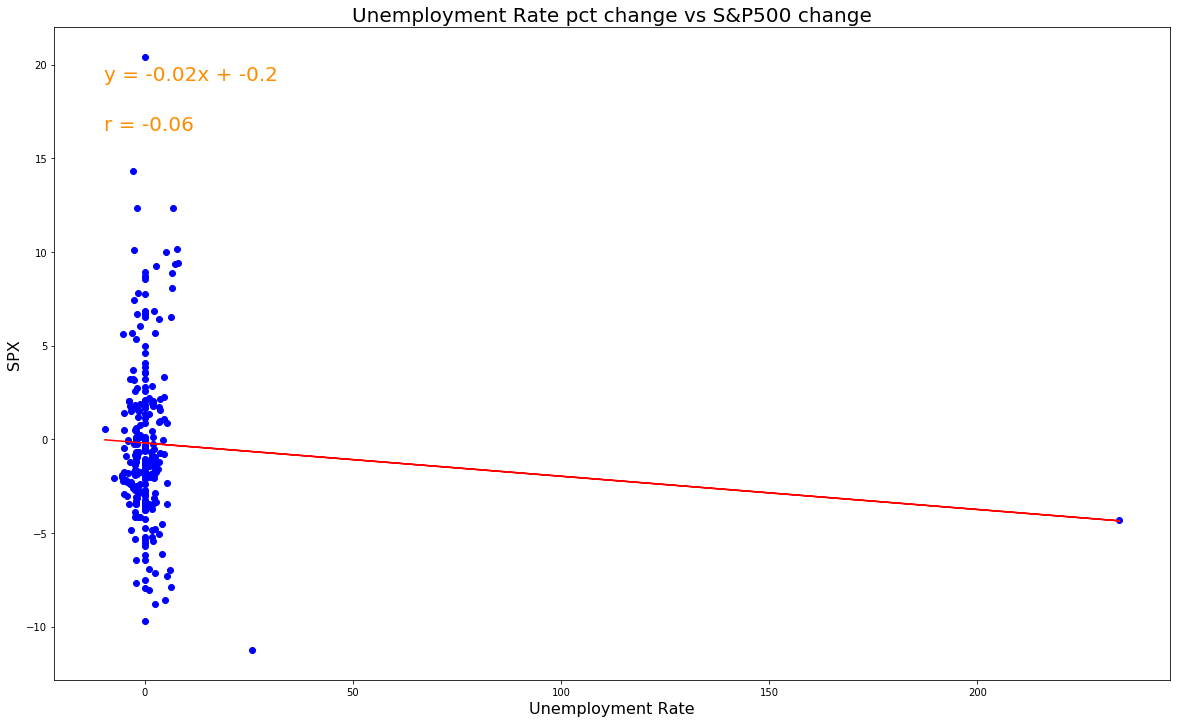

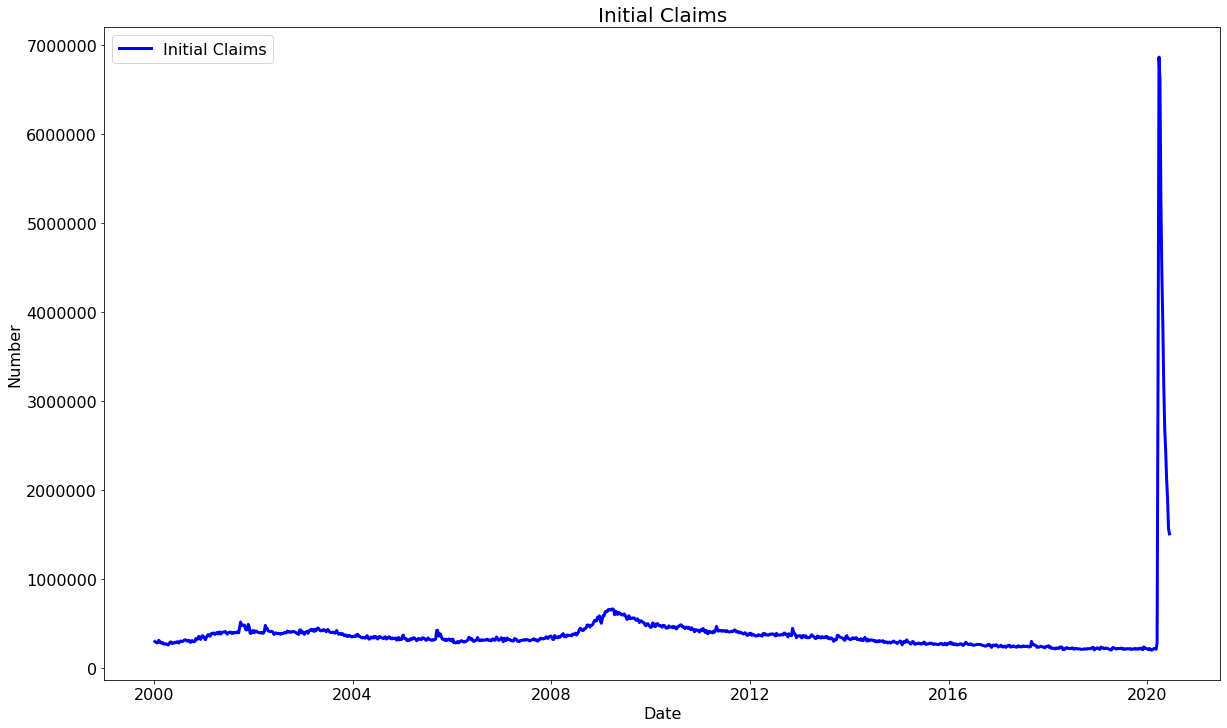

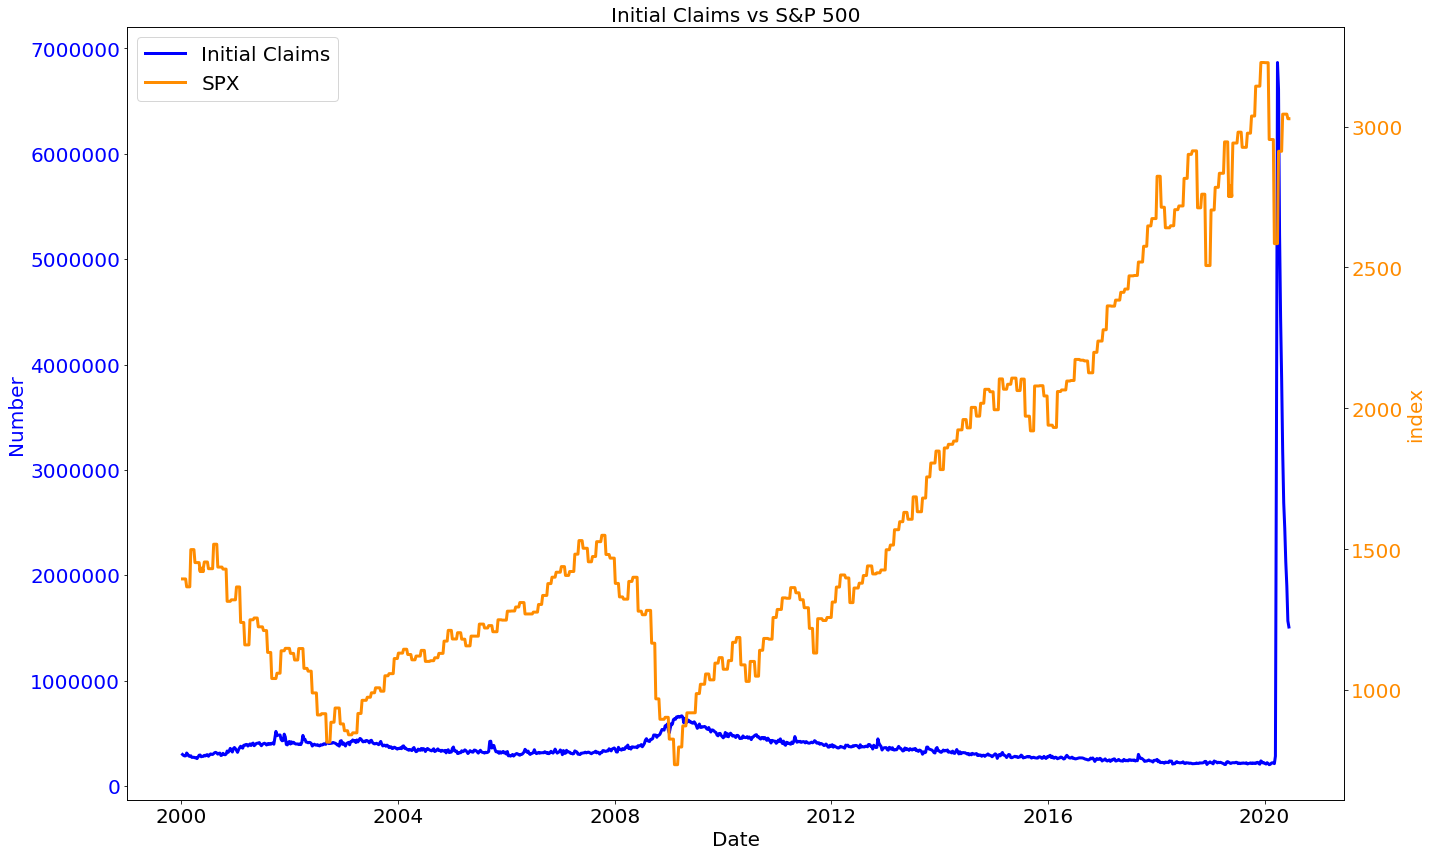

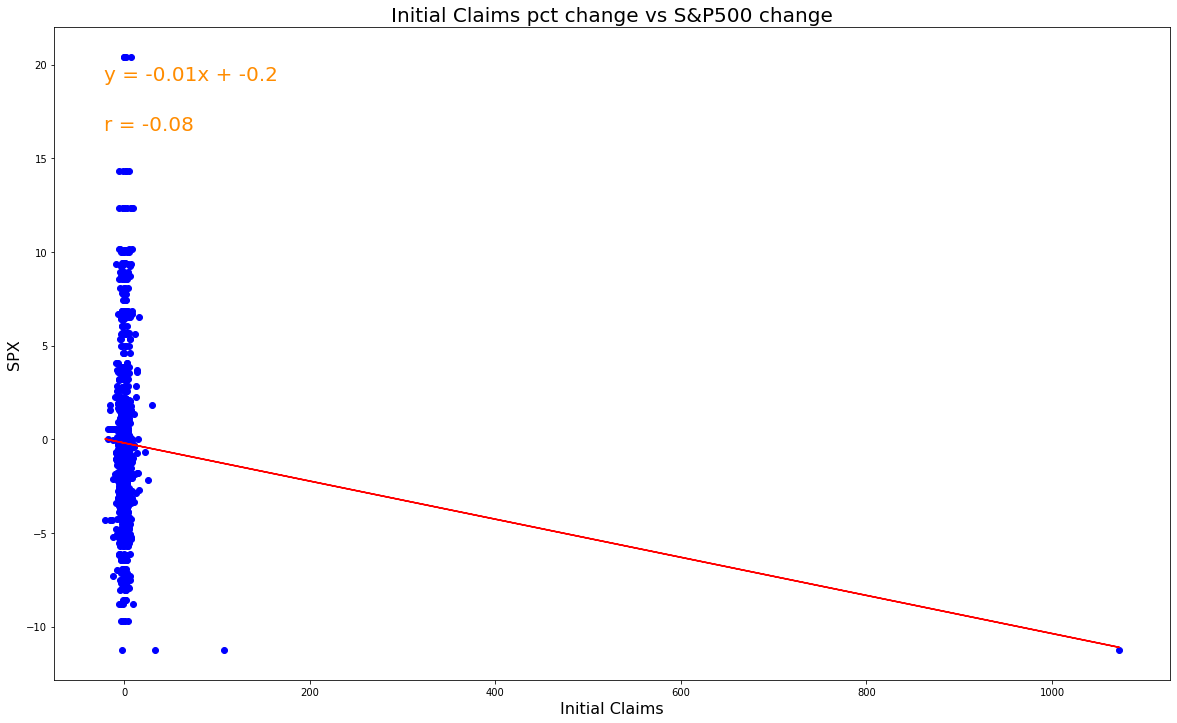

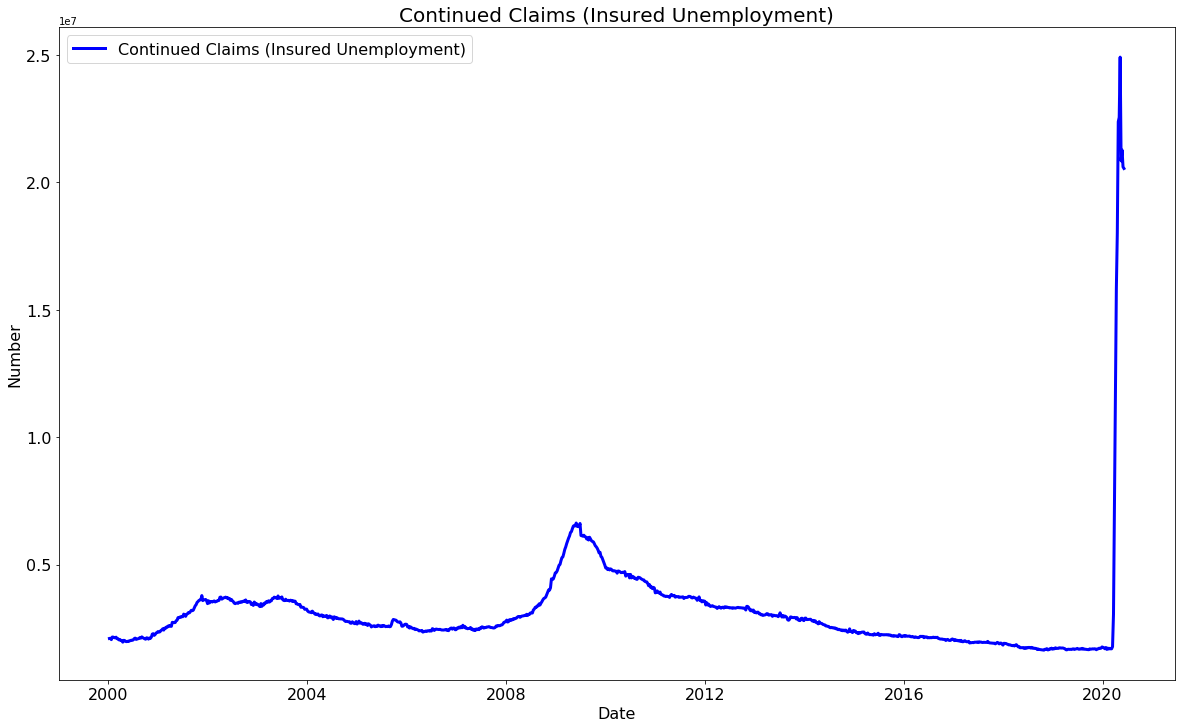

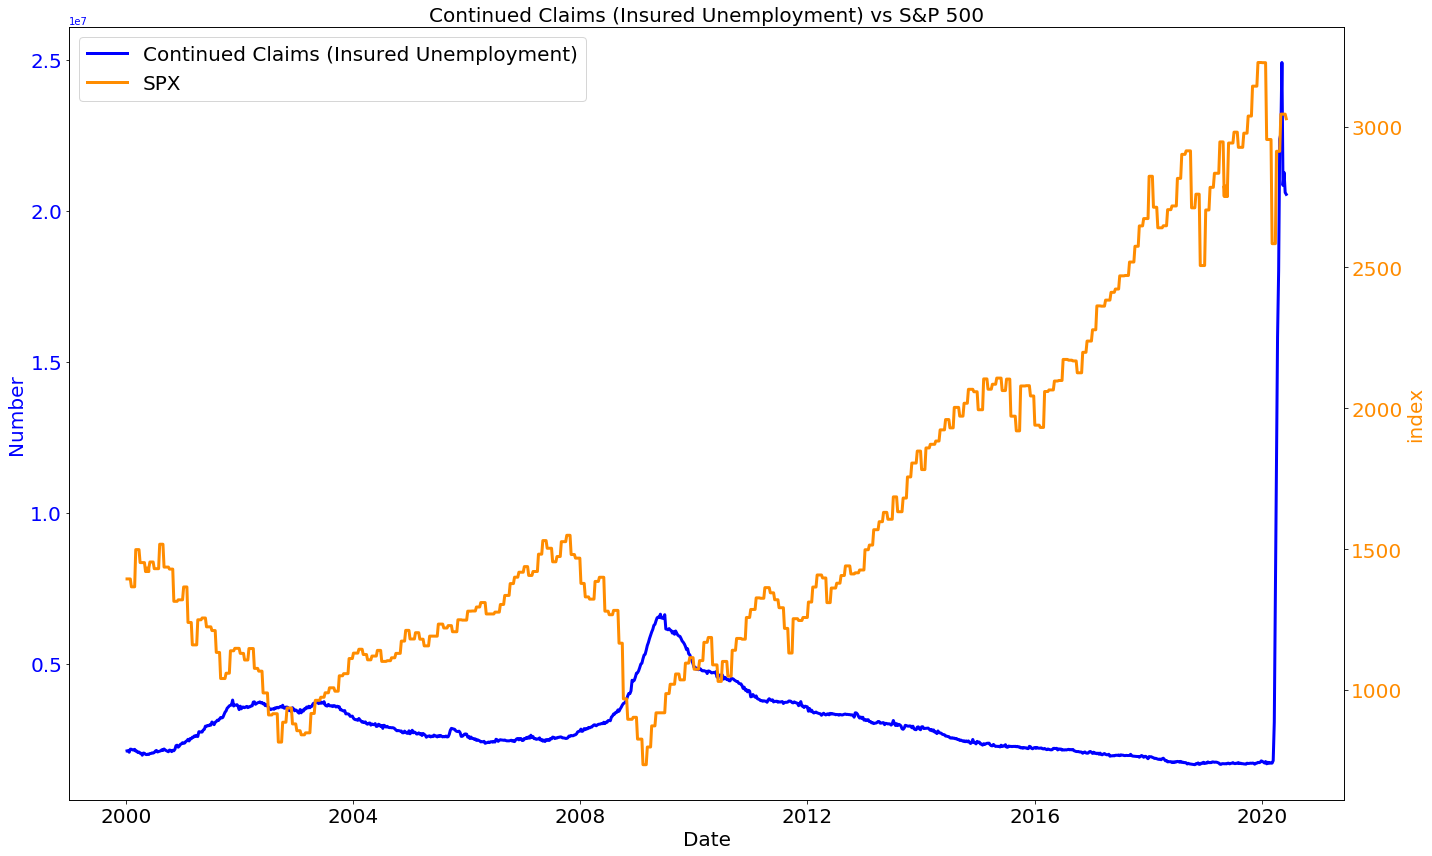

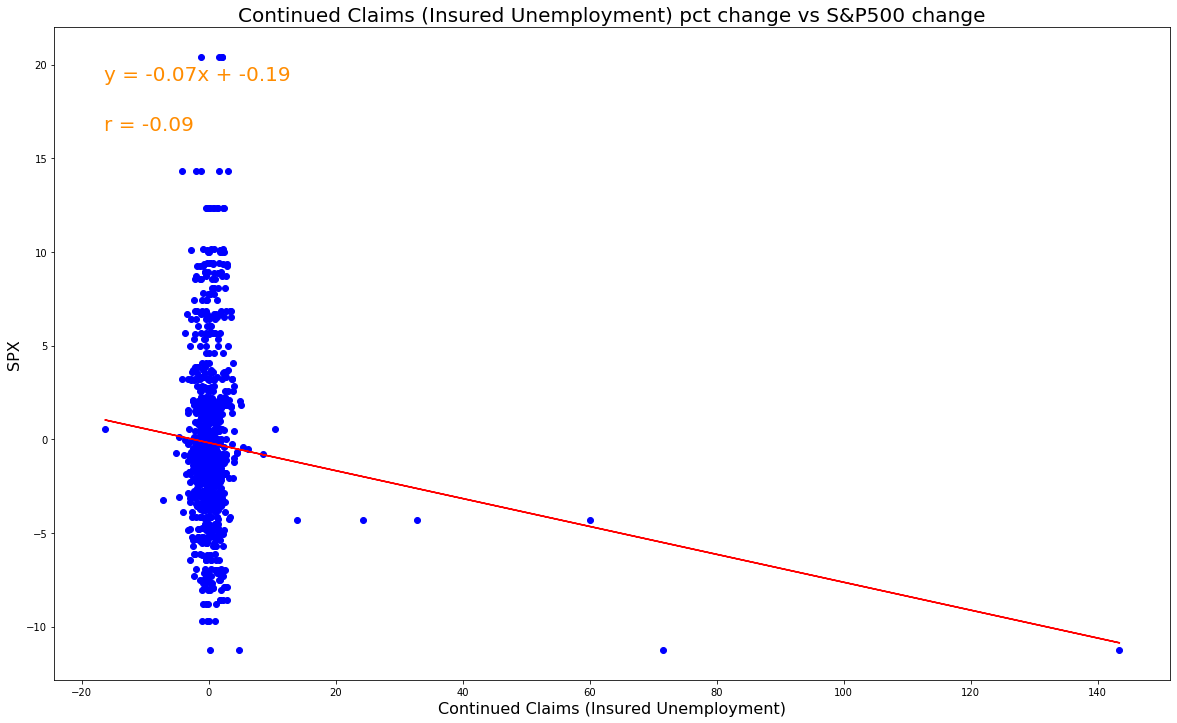

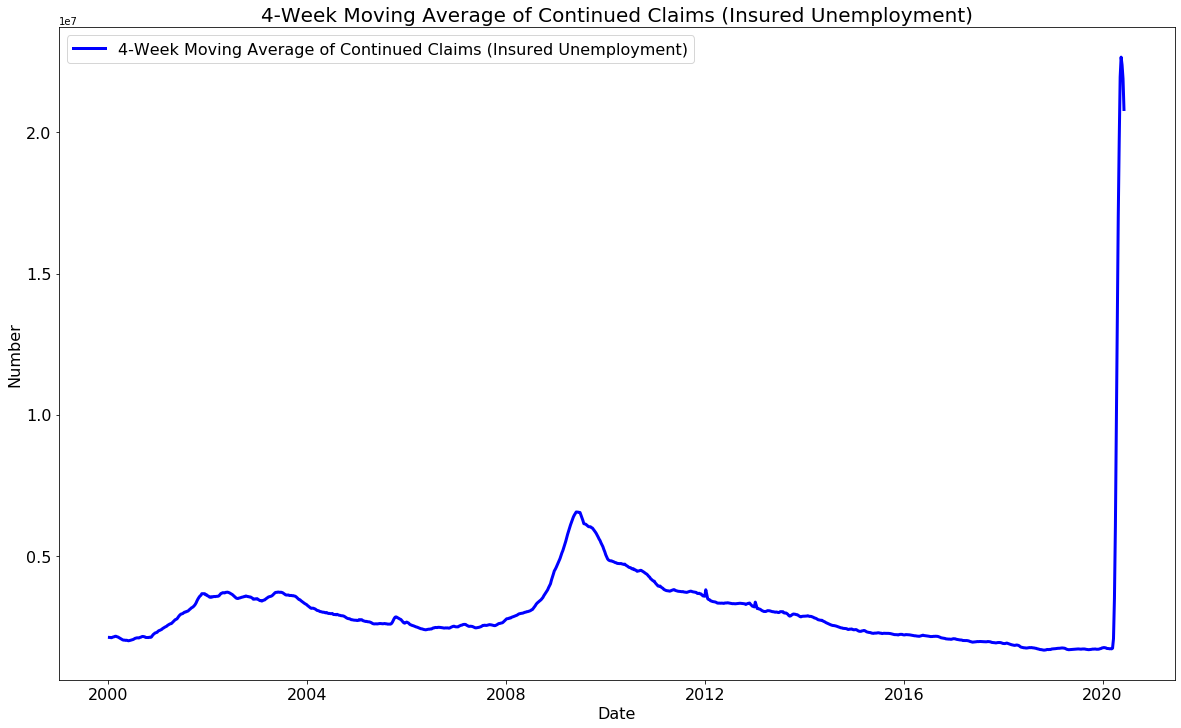

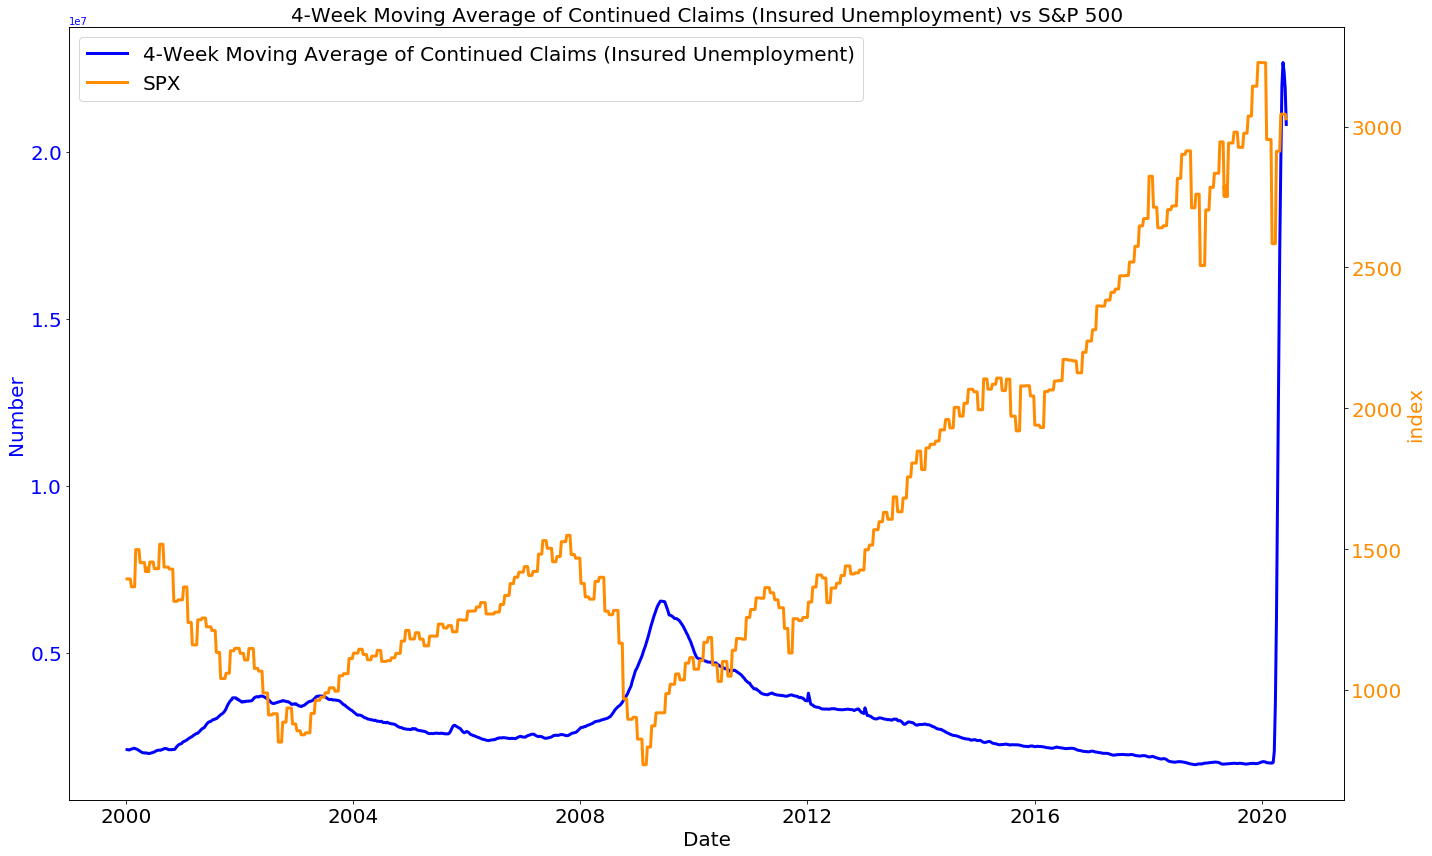

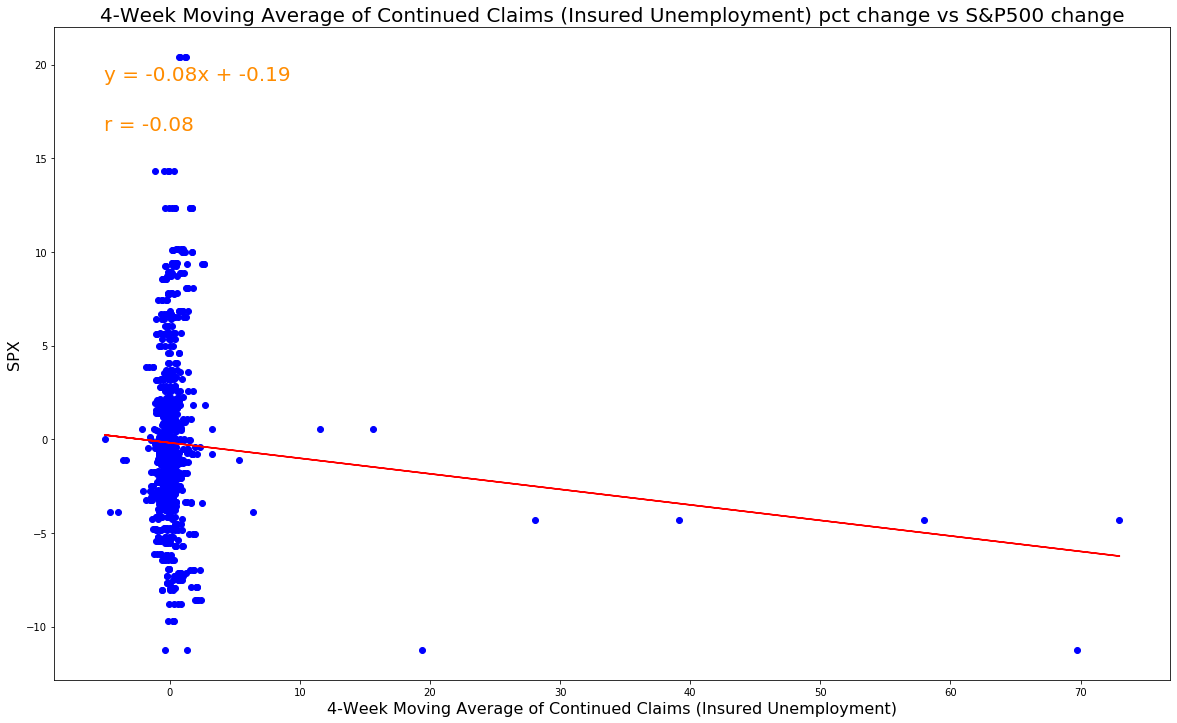

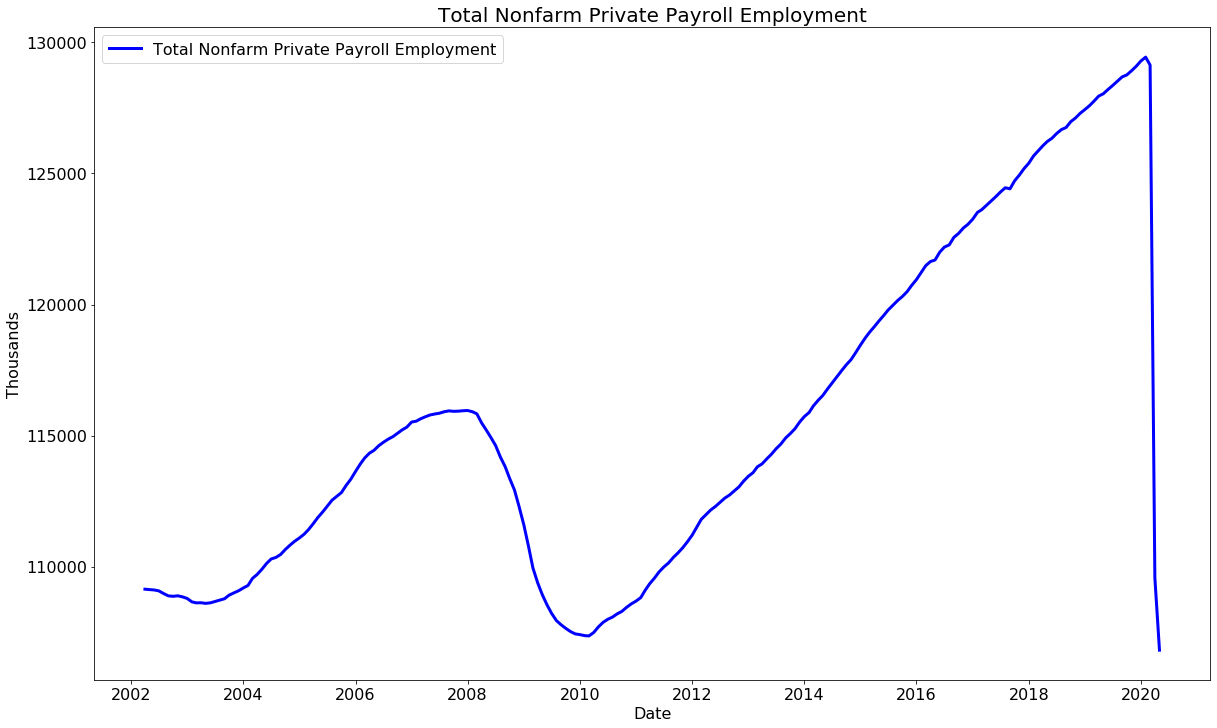

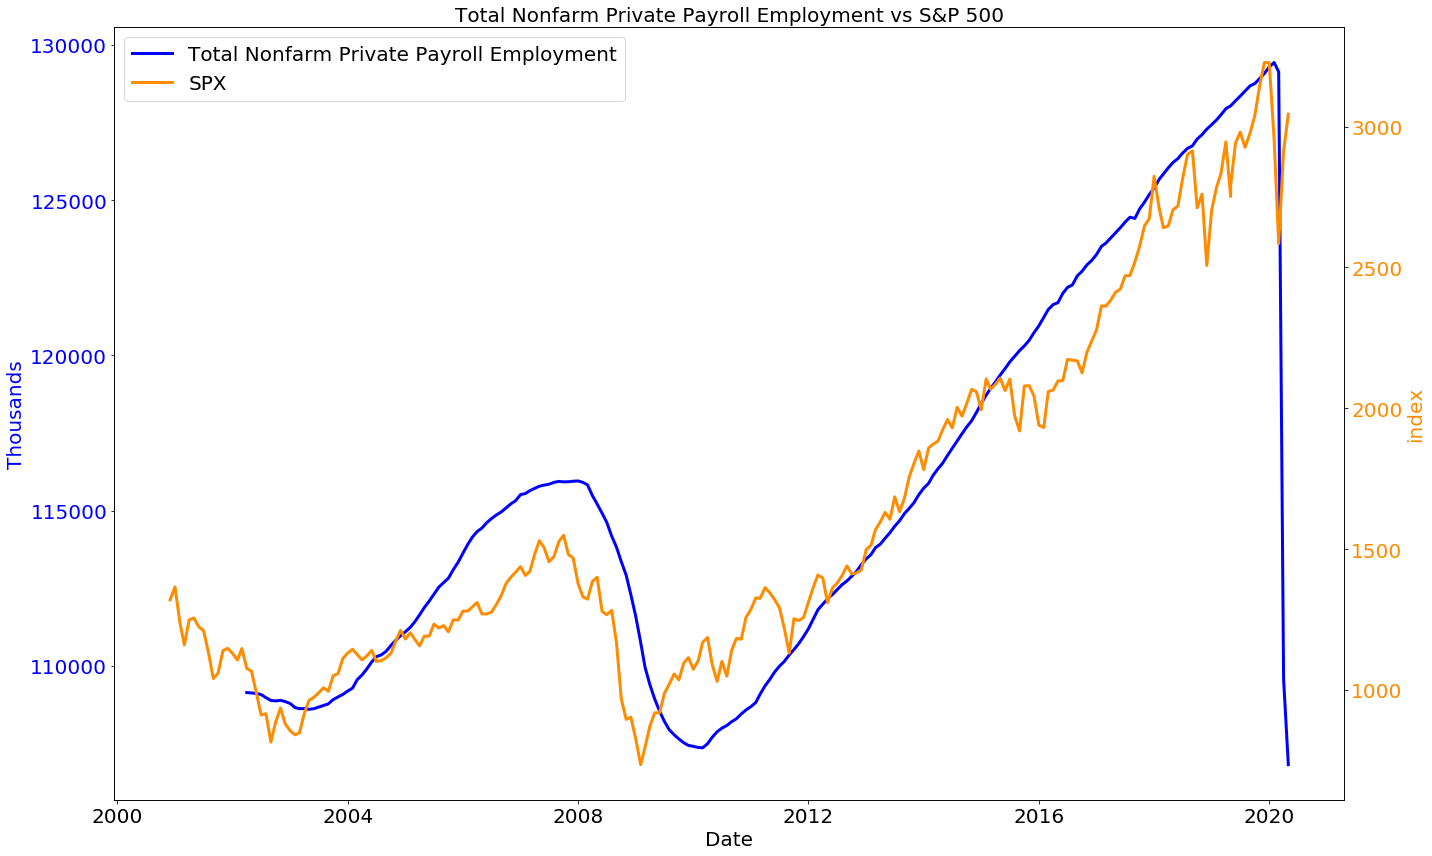

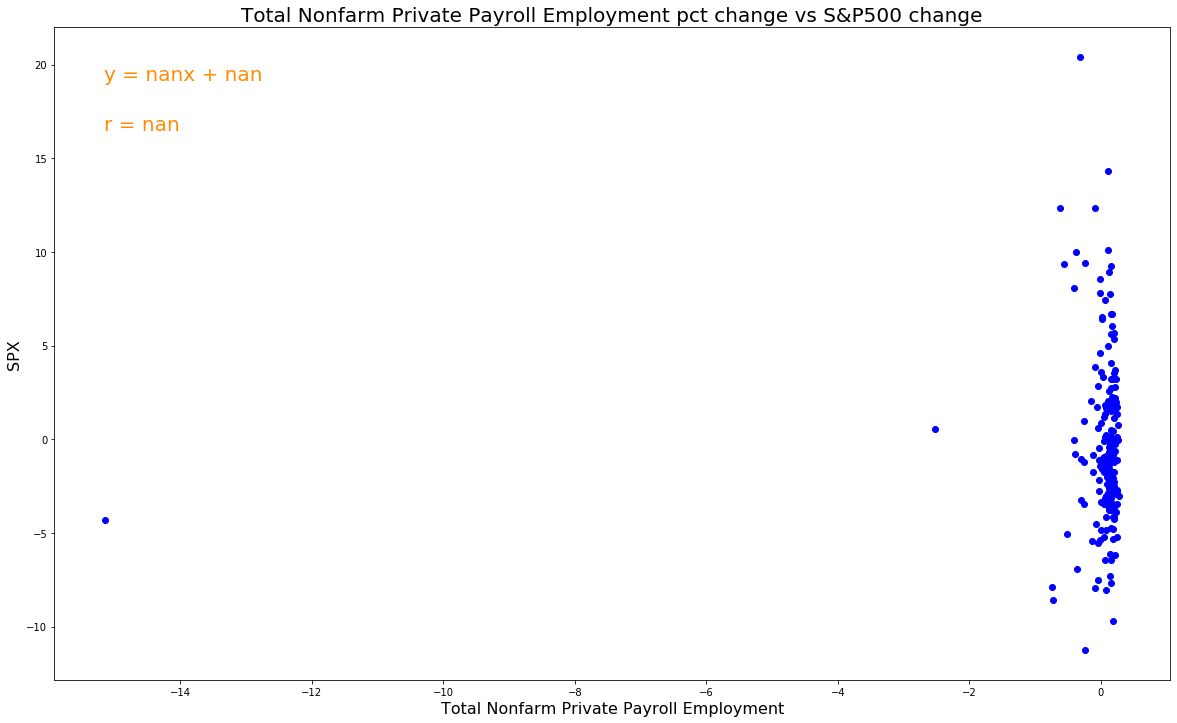

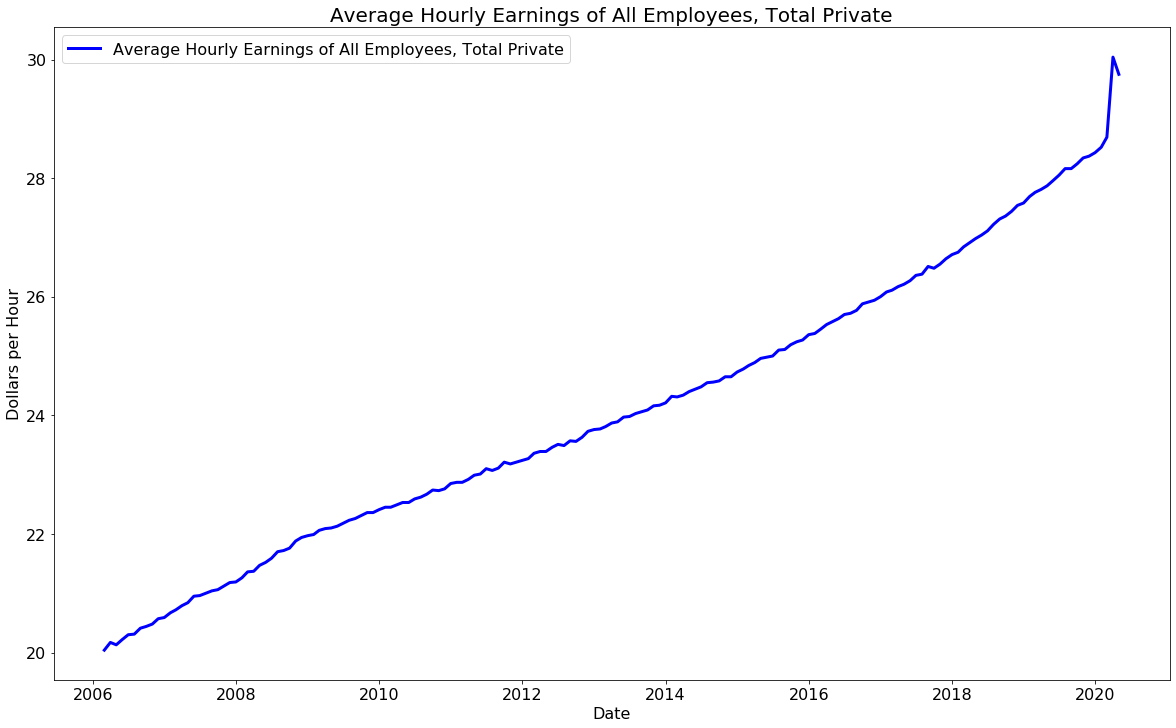

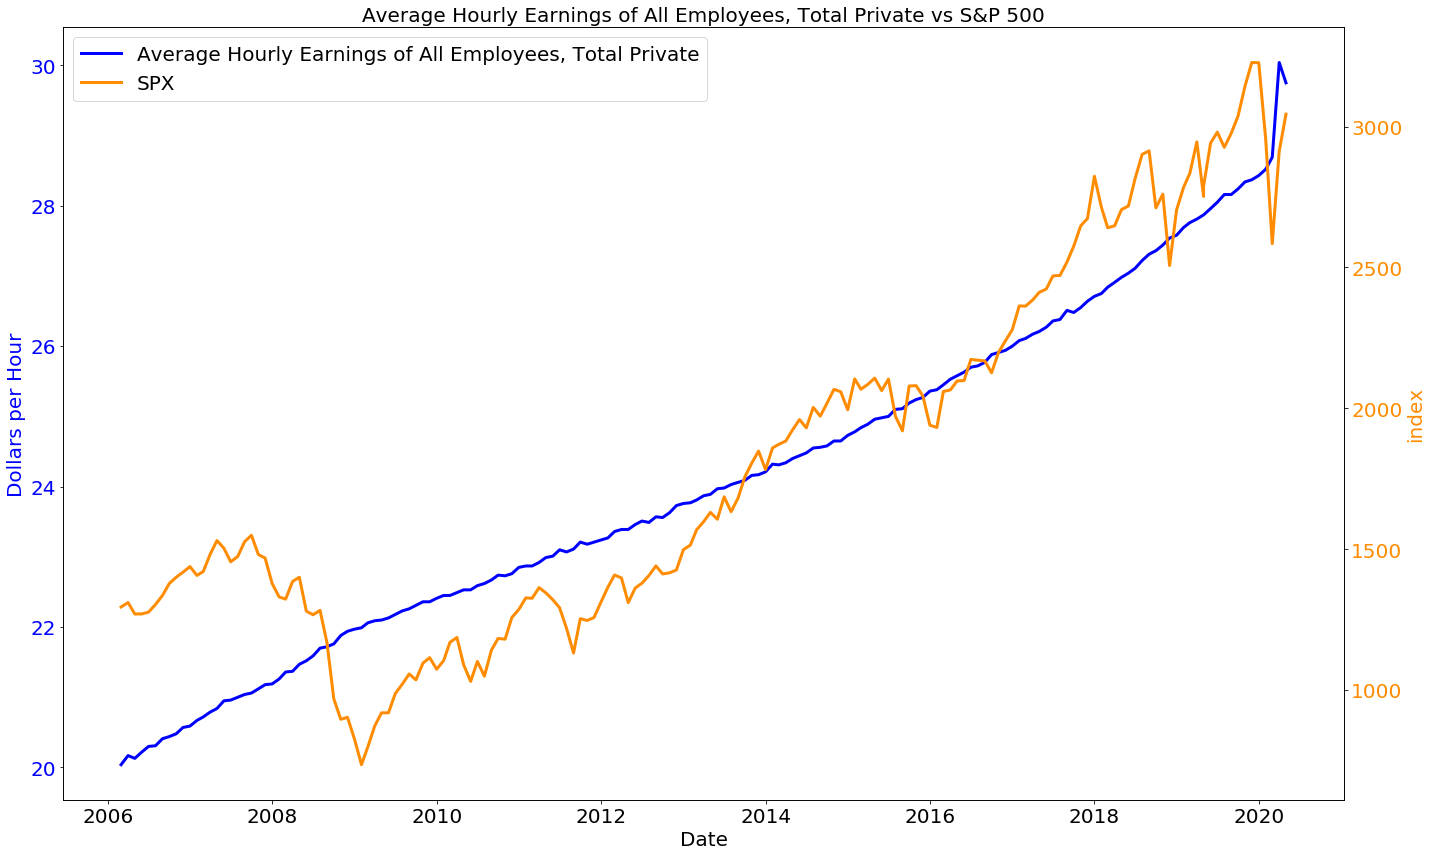

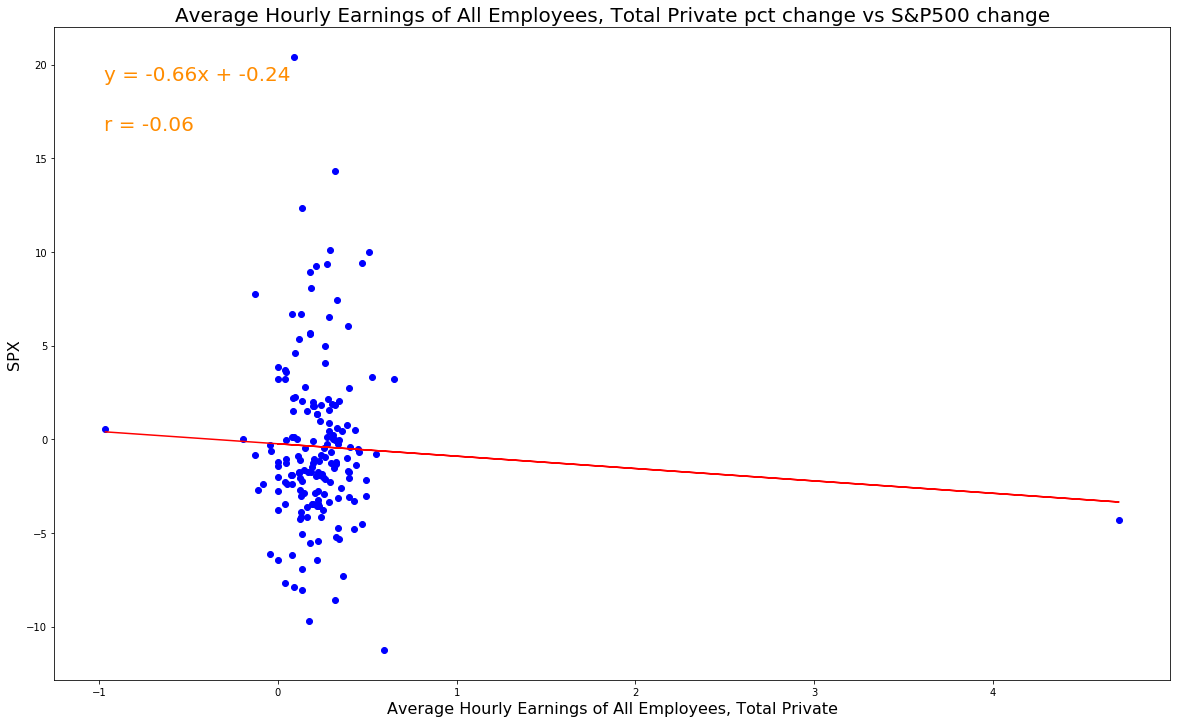

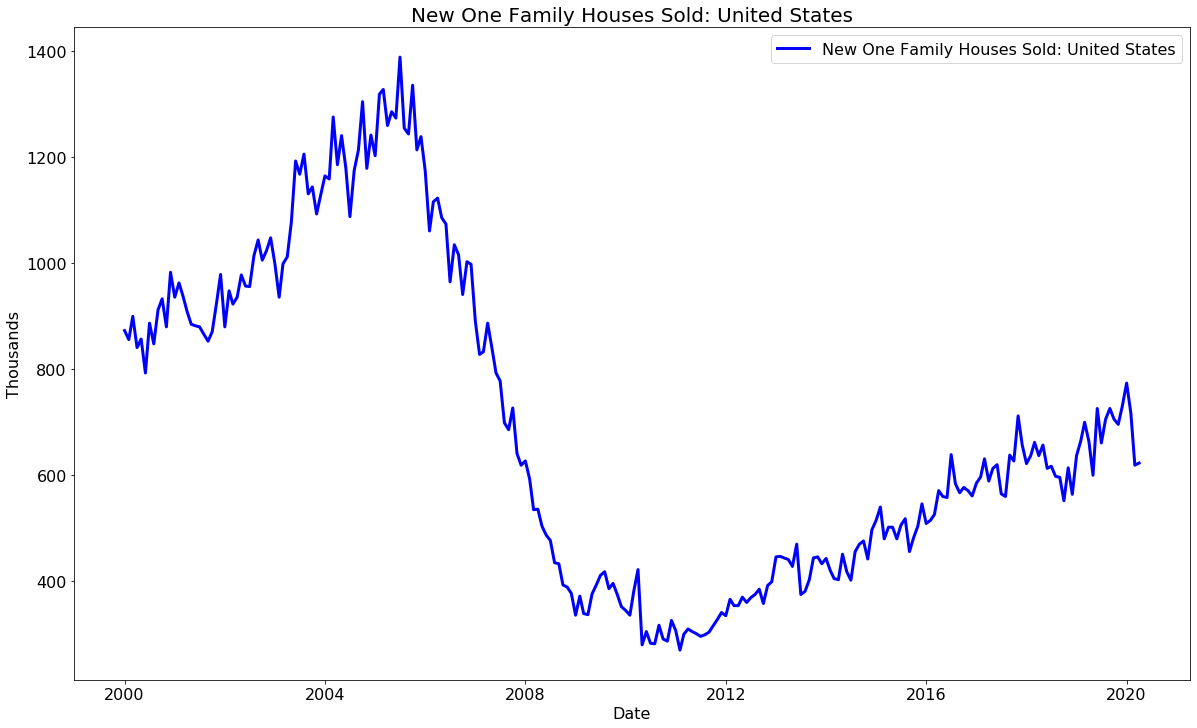

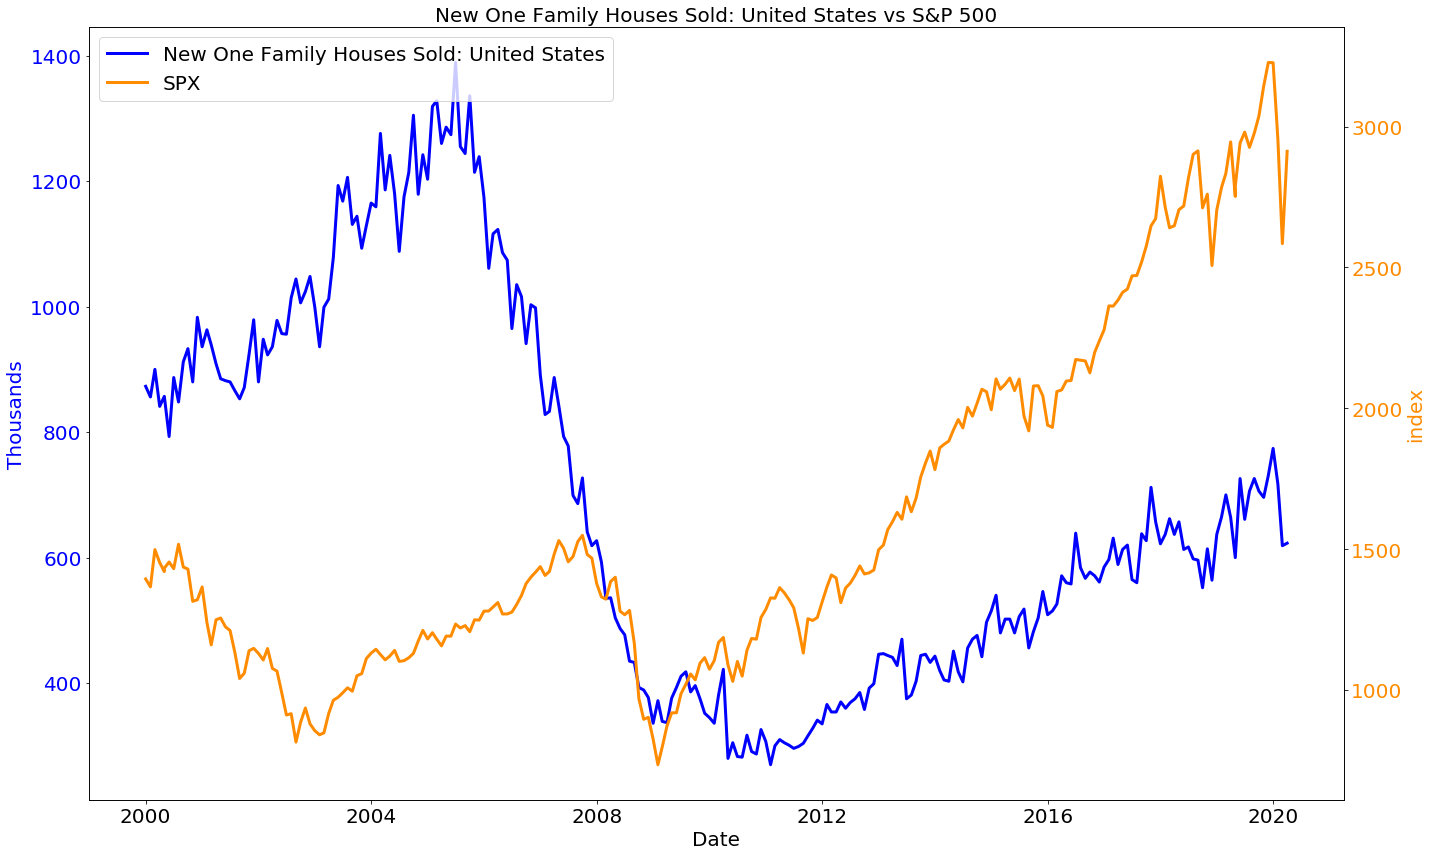

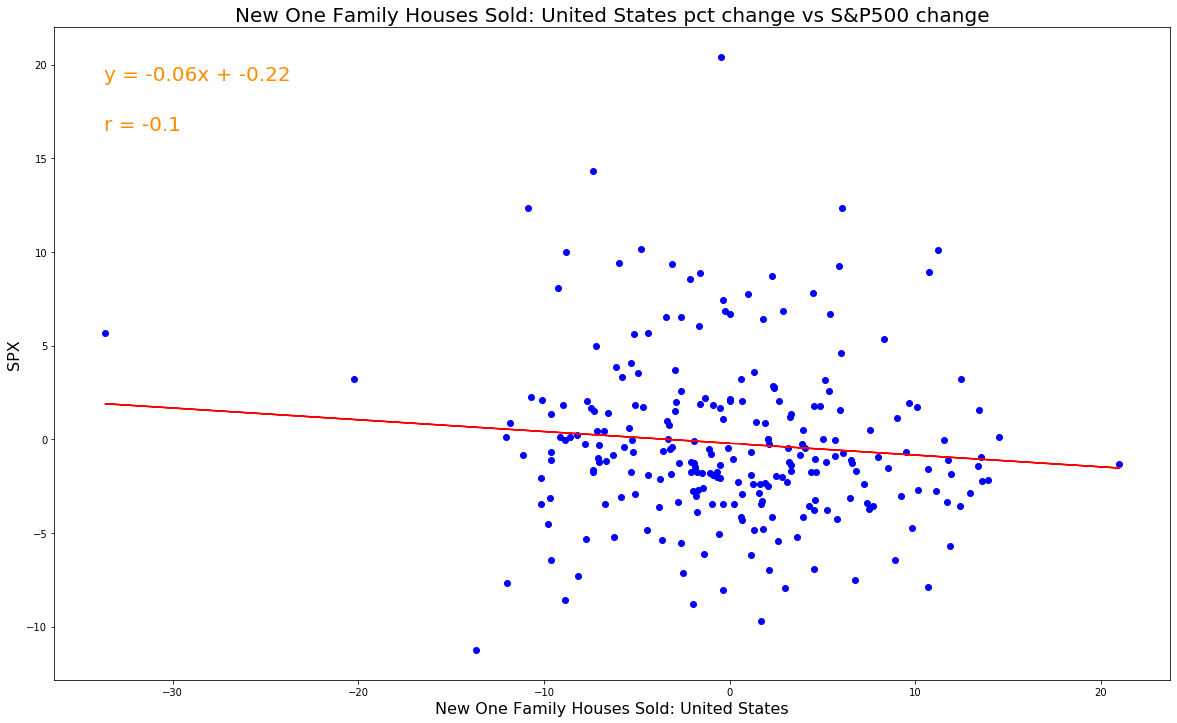

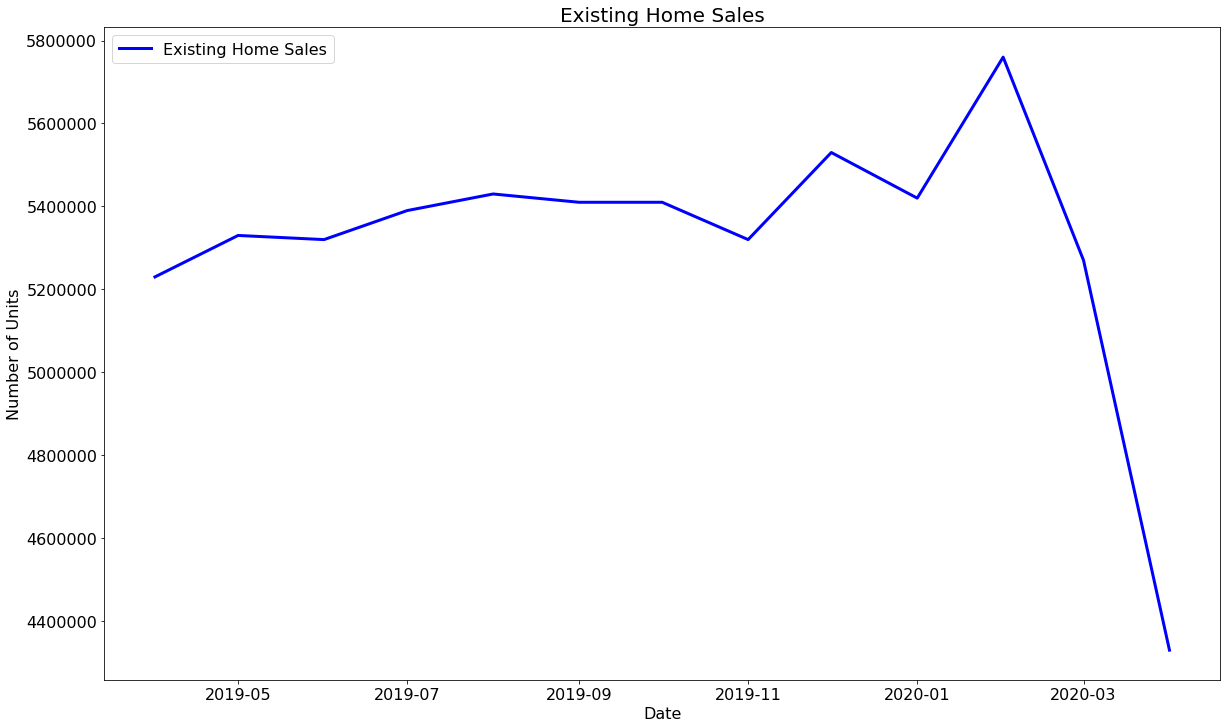

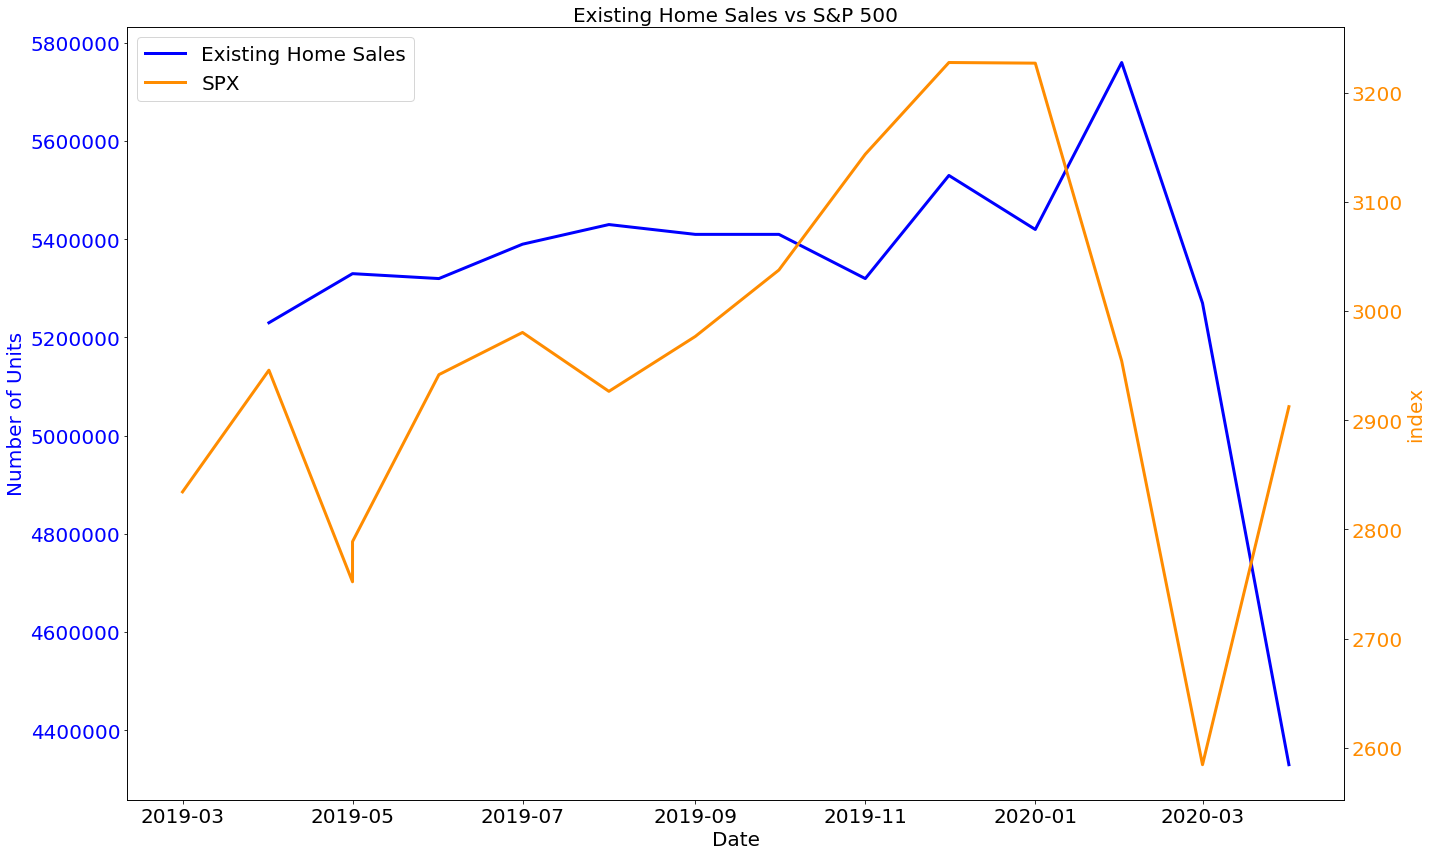

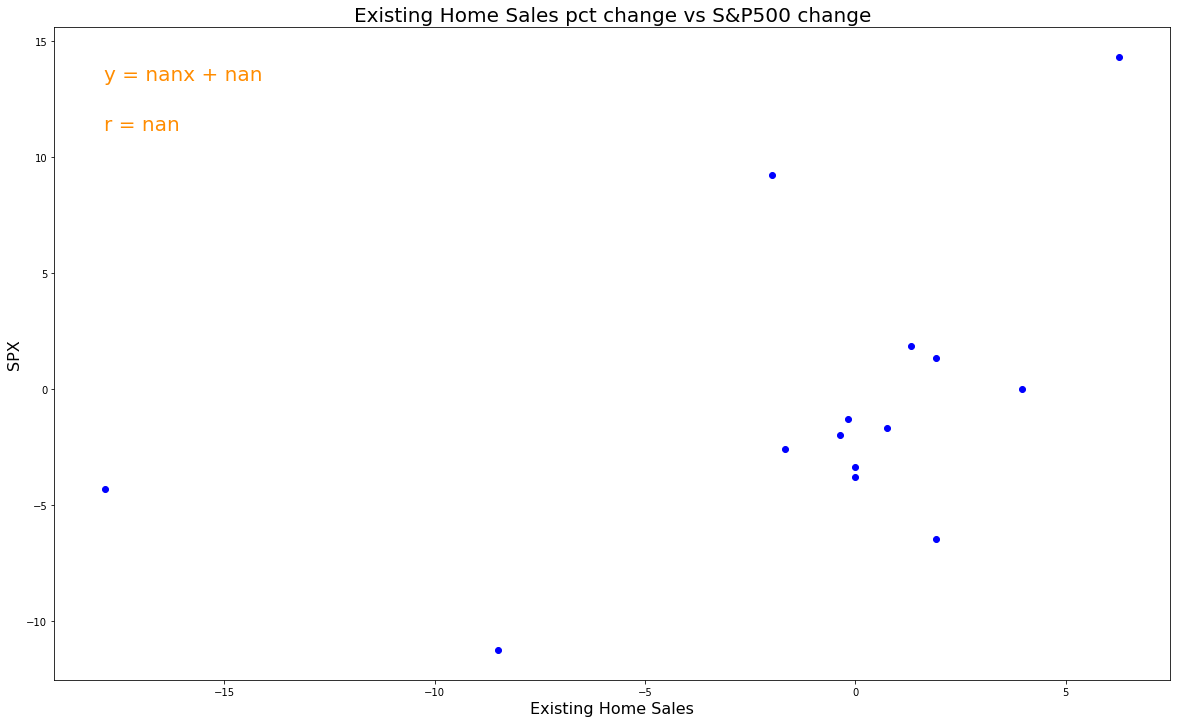

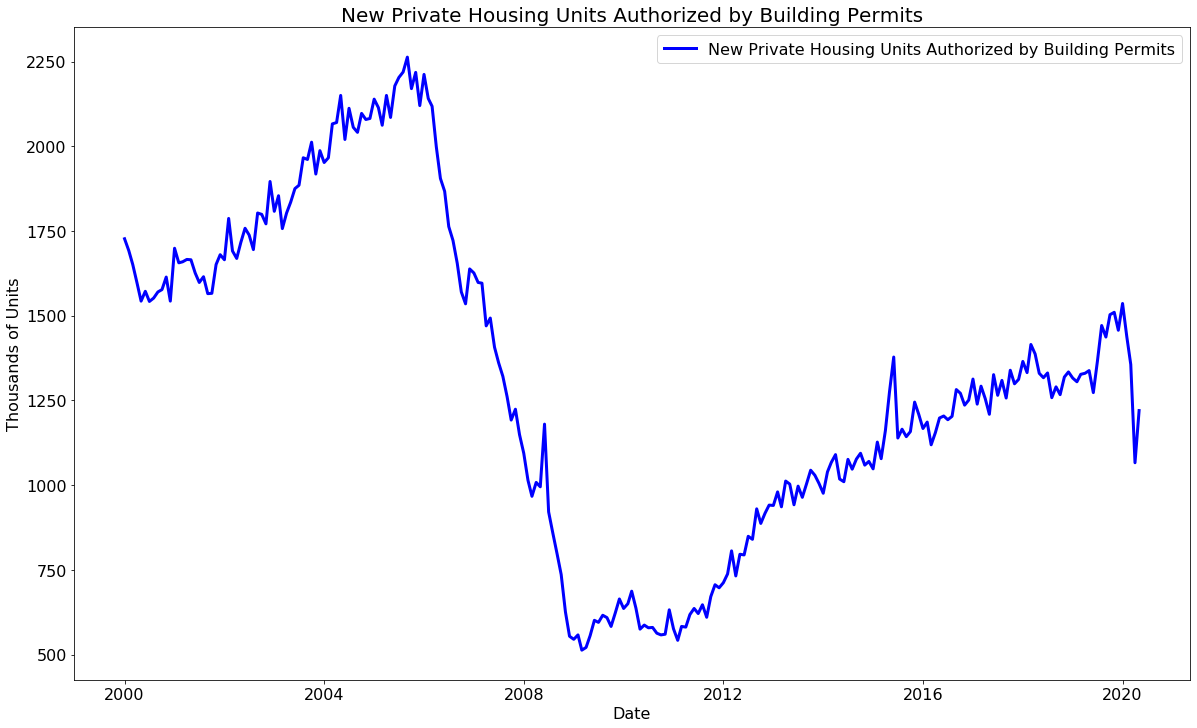

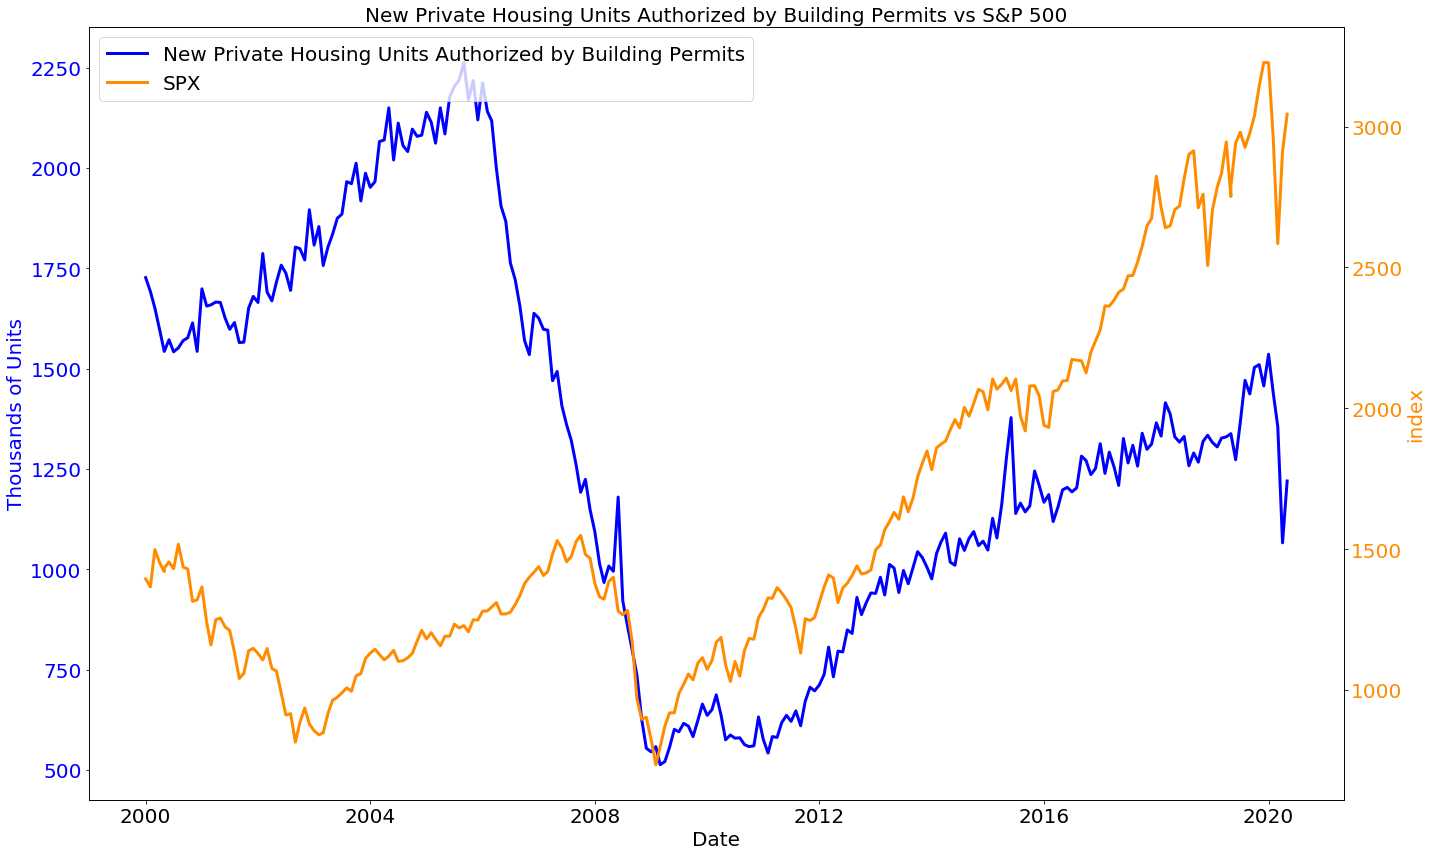

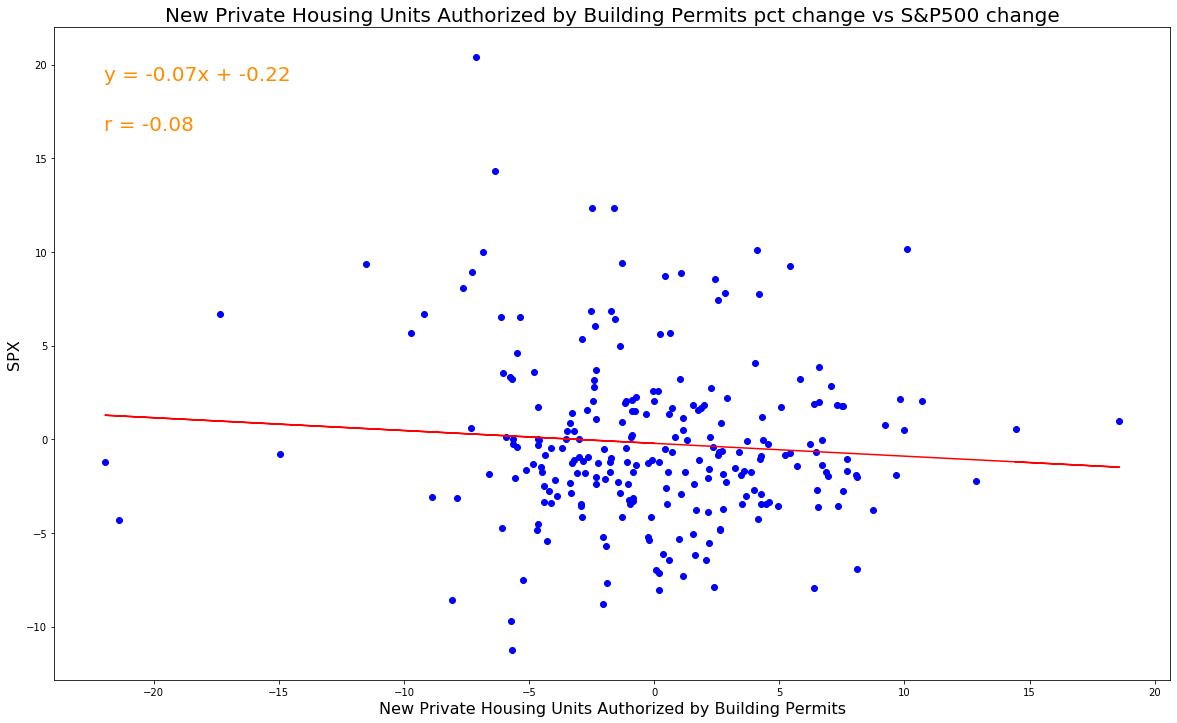

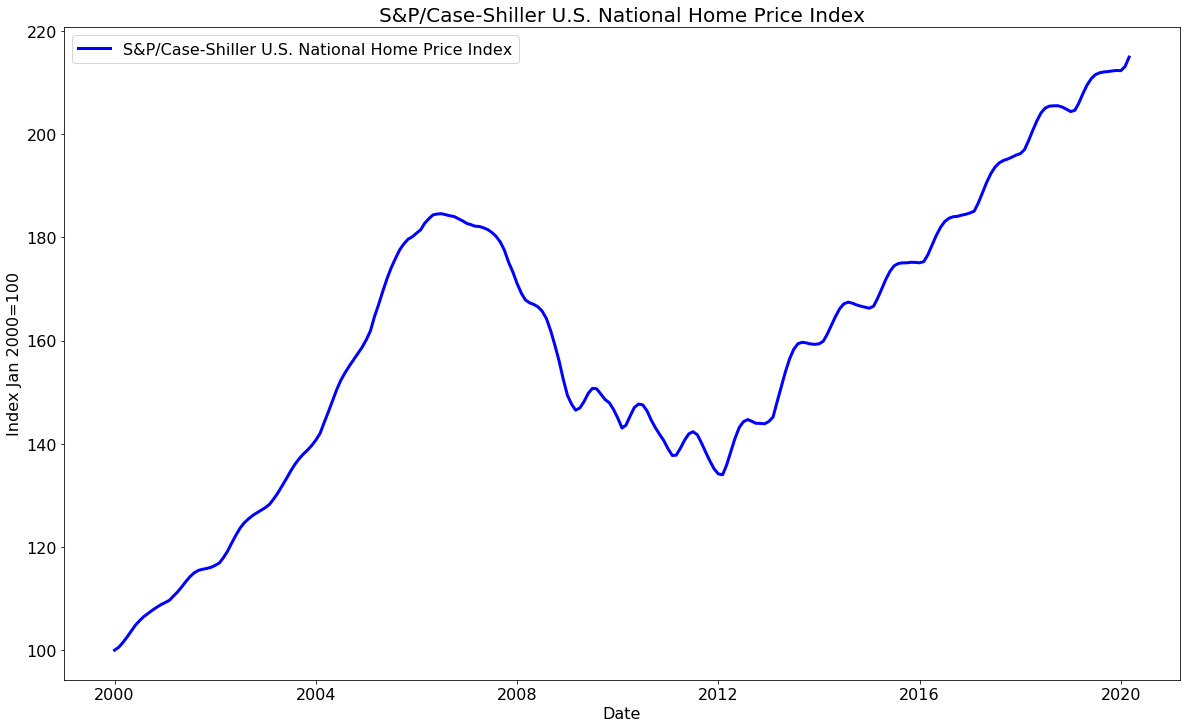

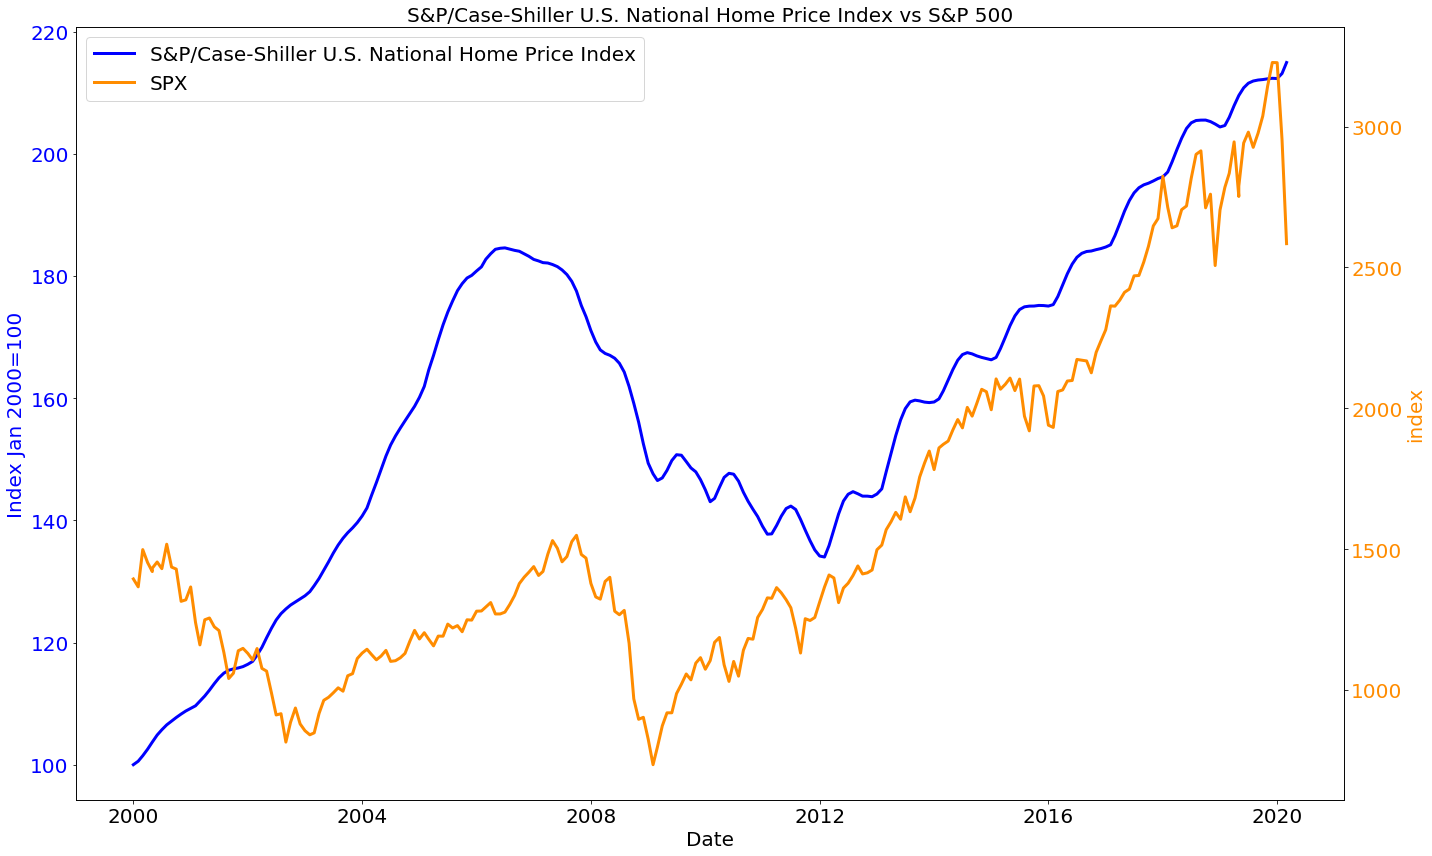

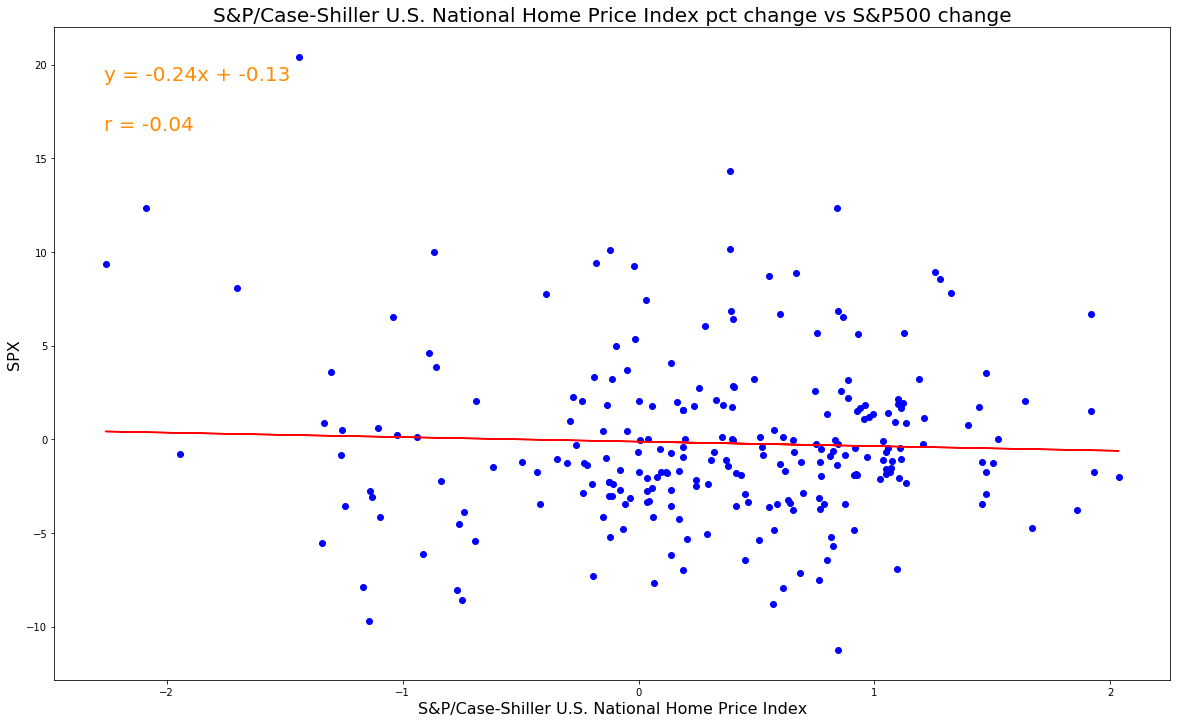

In [64]:
#create dataframe, charts and csv's for each indicator, load to AWS RDS and AWS S3
errors=[]
for indicator in tqdm_notebook(indicators):
    try:
        #get data and info series
        fred_df(indicator)
        #create month_year column for combine_df
        combine_df['month_year'] = pd.to_datetime(combine_df['date']).dt.strftime('%m-%Y')
        combine_df.to_csv(f"data/{indicator}.csv",index = False, header = True)
        #merge df's
        df = pd.merge(combine_df, spx_df, on= 'month_year')


        #line chart for indicator
        plt.figure(figsize=(20,12))
        plt.plot(df['date'],df['data'], color = "blue", label=f"{df.iloc[0,7]}", linewidth=3)
        plt.title(f"{df.iloc[0,7]}", fontsize=20)
        plt.xlabel("Date", fontsize=16)
        plt.ylabel(f"{df.iloc[0,12]}", fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(loc="best", fontsize=16)
        plt.savefig(f"images/{indicator}_line.png")

        #indicator level vs SPX level
        fig,ax1 = plt.subplots(figsize=(20,12))
        ax1.set_title(f"{df.iloc[0,7]} vs S&P 500", fontsize=20)
        ax1.set_xlabel("Date", fontsize=20)
        ax1.set_ylabel(f"{df.iloc[0,12]}", fontsize=20, color="blue")
        ax1.plot(df['date'],df['data'], color = "blue", label=f"{df.iloc[0,7]}", linewidth=3)
        ax1.tick_params(axis='y', labelcolor="blue", labelsize=20)
        ax1.tick_params(axis='x', labelsize=20)
        ax2 = ax1.twinx()
        ax2.set_ylabel("index", fontsize=20, color="darkorange")
        ax2.plot(df['date'],df['SPX Adj. Close'], color = "darkorange", label="SPX", linewidth=3)
        ax2.tick_params(axis='y', labelcolor="darkorange", labelsize=20)
        fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes, fontsize=20)
        fig.tight_layout()
        plt.savefig(f"images/{indicator}_spx_line.png")

        #run line regression
        plt.figure(figsize=(20,12))
        x_values = df['pct_change_x']
        y_values = df['pct_change_y']
        (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
        regress_values = x_values * slope + intercept
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        plt.scatter(x_values,y_values, color="blue")
        plt.plot(x_values,regress_values,"r-")
        plt.annotate(line_eq,(50,600),fontsize=20,color="darkorange", xycoords="axes points")
        plt.annotate(f'r = {str(round(rvalue,2))}',(50,550),fontsize=20,color="darkorange", xycoords="axes points")
        plt.title(f'{df.iloc[0,7]} pct change vs S&P500 change', fontsize=20)
        plt.xlabel(f"{df.iloc[0,7]}", fontsize=16)
        plt.ylabel("SPX", fontsize=16)
        plt.savefig(f"images/{indicator}_spx_regress.png")
        

        time.sleep(0.2)
        print(f'{indicator} retrieved.')
    except Exception as e: 
        print(f'error with {indicator} data. Proceeding...')
        print(e)
        errors.append(indicator)
        